<a href="https://colab.research.google.com/github/VLCHS/FCNN/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb==0.18.7
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 16.1 MB/s eta 0:00:00


In [2]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [3]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [5]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

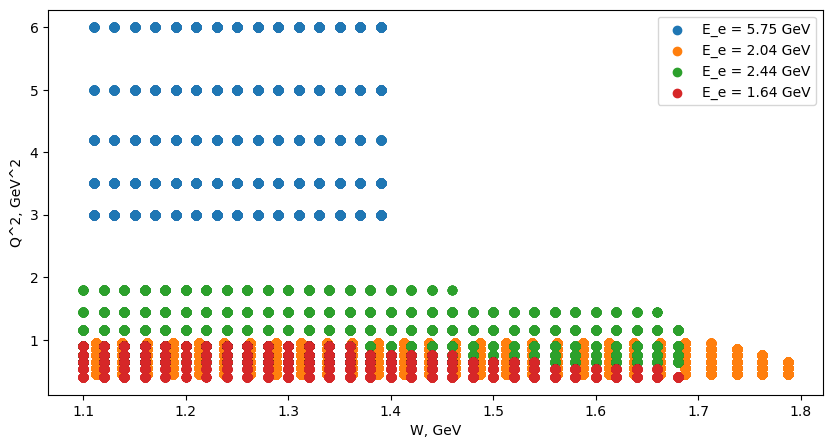

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [7]:
# Initialize wandb
run = wandb.init(project="FCNN for ep->ep_pi0, unified topology")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.sqrt(torch.mean((x - y)**2))
        return criterion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 20,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 50,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            augment_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(augment_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_df = pd.concat([augment_df, aug_df], ignore_index=True)
            train_label_data = augment_df["dsigma_dOmega"]
            train_feature_data = augment_df.loc[:, ~augment_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

In [10]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2024-12-08 18:08:01,688 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2024-12-08 18:08:01,694 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-08 18:08:01,700 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-08 18:08:01,710 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2024-12-08 18:08:02,556 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2024-12-08 18:08:02,659 : INFO : Training is starting
2024-12-08 18:09:15,926 : INFO : epoch: 0; val_loss: 1.7794643640518188
2024-

INFO: Metric val_loss improved. New best score: 1.779


2024-12-08 18:09:16,047 : INFO : Metric val_loss improved. New best score: 1.779
2024-12-08 18:09:16,944 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=1.77946-epoch=00.ckpt
2024-12-08 18:10:23,203 : INFO : epoch: 1; val_loss: 1.325988531112671
2024-12-08 18:10:23,217 : INFO : epoch: 1; train_loss: 1.5285589694976807


INFO: Metric val_loss improved by 0.453 >= min_delta = 1e-05. New best score: 1.326


2024-12-08 18:10:23,287 : INFO : Metric val_loss improved by 0.453 >= min_delta = 1e-05. New best score: 1.326
2024-12-08 18:10:23,594 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=1.32599-epoch=01.ckpt
2024-12-08 18:11:39,850 : INFO : epoch: 2; val_loss: 1.1035997867584229
2024-12-08 18:11:39,866 : INFO : epoch: 2; train_loss: 1.1437827348709106


INFO: Metric val_loss improved by 0.222 >= min_delta = 1e-05. New best score: 1.104


2024-12-08 18:11:39,939 : INFO : Metric val_loss improved by 0.222 >= min_delta = 1e-05. New best score: 1.104
2024-12-08 18:11:40,253 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=1.10360-epoch=02.ckpt
2024-12-08 18:13:06,056 : INFO : epoch: 3; val_loss: 0.9243782162666321
2024-12-08 18:13:06,075 : INFO : epoch: 3; train_loss: 1.0313977003097534


INFO: Metric val_loss improved by 0.179 >= min_delta = 1e-05. New best score: 0.924


2024-12-08 18:13:06,162 : INFO : Metric val_loss improved by 0.179 >= min_delta = 1e-05. New best score: 0.924
2024-12-08 18:13:06,459 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.92438-epoch=03.ckpt
2024-12-08 18:14:32,876 : INFO : epoch: 4; val_loss: 1.2543920278549194
2024-12-08 18:14:32,897 : INFO : epoch: 4; train_loss: 1.0024937391281128
2024-12-08 18:14:33,170 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=1.25439-epoch=04.ckpt
2024-12-08 18:16:00,470 : INFO : epoch: 5; val_loss: 1.3048173189163208
2024-12-08 18:16:00,486 : INFO : epoch: 5; train_loss: 0.9561159014701843
2024-12-08 18:17:26,118 : INFO : epoch: 6; val_loss: 0.9253150820732117
2024-12-08 18:17:26,132 : INFO : epoch: 6; train_loss: 0.8808728456497192
2024-12-08 18:17:26,325 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, uni

INFO: Metric val_loss improved by 0.166 >= min_delta = 1e-05. New best score: 0.758


2024-12-08 18:18:54,333 : INFO : Metric val_loss improved by 0.166 >= min_delta = 1e-05. New best score: 0.758
2024-12-08 18:18:54,557 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.75800-epoch=07.ckpt
2024-12-08 18:20:21,848 : INFO : epoch: 8; val_loss: 0.7592008709907532
2024-12-08 18:20:21,866 : INFO : epoch: 8; train_loss: 0.8446170687675476
2024-12-08 18:20:22,244 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.75920-epoch=08.ckpt
2024-12-08 18:21:49,381 : INFO : epoch: 9; val_loss: 0.9101768136024475
2024-12-08 18:21:49,400 : INFO : epoch: 9; train_loss: 0.840058445930481
2024-12-08 18:21:49,888 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.91018-epoch=09.ckpt
2024-12-08 18:23:16,583 : INFO : epoch: 10; val_loss: 0.73683404

INFO: Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 0.737


2024-12-08 18:23:16,669 : INFO : Metric val_loss improved by 0.021 >= min_delta = 1e-05. New best score: 0.737
2024-12-08 18:23:16,996 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.73683-epoch=10.ckpt
2024-12-08 18:24:43,030 : INFO : epoch: 11; val_loss: 0.7305691242218018
2024-12-08 18:24:43,044 : INFO : epoch: 11; train_loss: 0.815112829208374


INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.731


2024-12-08 18:24:43,112 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.731
2024-12-08 18:24:43,410 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.73057-epoch=11.ckpt
2024-12-08 18:26:09,191 : INFO : epoch: 12; val_loss: 0.7446854114532471
2024-12-08 18:26:09,207 : INFO : epoch: 12; train_loss: 0.7904072999954224
2024-12-08 18:26:09,545 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.74469-epoch=12.ckpt
2024-12-08 18:27:35,447 : INFO : epoch: 13; val_loss: 0.7935477495193481
2024-12-08 18:27:35,464 : INFO : epoch: 13; train_loss: 0.8133988380432129
2024-12-08 18:29:04,686 : INFO : epoch: 14; val_loss: 0.9293670654296875
2024-12-08 18:29:04,759 : INFO : epoch: 14; train_loss: 0.7960696220397949
2024-12-08 18:30:30,887 : INFO : epoch: 15; val_loss: 0.7800688743591309
2024-12-08 18:30

INFO: Metric val_loss improved by 0.020 >= min_delta = 1e-05. New best score: 0.711


2024-12-08 18:31:57,460 : INFO : Metric val_loss improved by 0.020 >= min_delta = 1e-05. New best score: 0.711
2024-12-08 18:31:57,698 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.71089-epoch=16.ckpt
2024-12-08 18:33:25,506 : INFO : epoch: 17; val_loss: 0.7110328674316406
2024-12-08 18:33:25,525 : INFO : epoch: 17; train_loss: 0.722649335861206
2024-12-08 18:33:25,827 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.71103-epoch=17.ckpt
2024-12-08 18:34:52,561 : INFO : epoch: 18; val_loss: 0.6968178749084473
2024-12-08 18:34:52,578 : INFO : epoch: 18; train_loss: 0.7039135694503784


INFO: Metric val_loss improved by 0.014 >= min_delta = 1e-05. New best score: 0.697


2024-12-08 18:34:52,670 : INFO : Metric val_loss improved by 0.014 >= min_delta = 1e-05. New best score: 0.697
2024-12-08 18:34:52,997 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.69682-epoch=18.ckpt
2024-12-08 18:36:18,803 : INFO : epoch: 19; val_loss: 0.7550432085990906
2024-12-08 18:36:18,818 : INFO : epoch: 19; train_loss: 0.7196486592292786
2024-12-08 18:37:44,701 : INFO : epoch: 20; val_loss: 0.7860087752342224
2024-12-08 18:37:44,716 : INFO : epoch: 20; train_loss: 0.7412053346633911
2024-12-08 18:39:12,659 : INFO : epoch: 21; val_loss: 0.6972193717956543
2024-12-08 18:39:12,678 : INFO : epoch: 21; train_loss: 0.7181639671325684
2024-12-08 18:39:13,025 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.69722-epoch=21.ckpt
2024-12-08 18:40:39,310 : INFO : epoch: 22; val_loss: 0.7156537175178528
2024-12-08 18:40

INFO: Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.694


2024-12-08 18:43:32,462 : INFO : Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.694
2024-12-08 18:43:32,751 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.69391-epoch=24.ckpt
2024-12-08 18:44:59,638 : INFO : epoch: 25; val_loss: 0.7515333890914917
2024-12-08 18:44:59,653 : INFO : epoch: 25; train_loss: 0.7024806141853333
2024-12-08 18:46:26,075 : INFO : epoch: 26; val_loss: 0.7190791368484497
2024-12-08 18:46:26,090 : INFO : epoch: 26; train_loss: 0.7090137600898743
2024-12-08 18:47:51,888 : INFO : epoch: 27; val_loss: 0.7262736558914185
2024-12-08 18:47:51,903 : INFO : epoch: 27; train_loss: 0.7281585931777954
2024-12-08 18:49:17,544 : INFO : epoch: 28; val_loss: 0.6893845796585083
2024-12-08 18:49:17,559 : INFO : epoch: 28; train_loss: 0.699164867401123


INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.689


2024-12-08 18:49:17,630 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.689
2024-12-08 18:49:17,873 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.68938-epoch=28.ckpt
2024-12-08 18:50:44,474 : INFO : epoch: 29; val_loss: 0.7656973600387573
2024-12-08 18:50:44,488 : INFO : epoch: 29; train_loss: 0.7151042222976685
2024-12-08 18:52:13,260 : INFO : epoch: 30; val_loss: 0.7049243450164795
2024-12-08 18:52:13,281 : INFO : epoch: 30; train_loss: 0.703130841255188
2024-12-08 18:53:40,561 : INFO : epoch: 31; val_loss: 0.6971766948699951
2024-12-08 18:53:40,580 : INFO : epoch: 31; train_loss: 0.7073748111724854
2024-12-08 18:55:07,802 : INFO : epoch: 32; val_loss: 0.6975415945053101
2024-12-08 18:55:07,816 : INFO : epoch: 32; train_loss: 0.6992260217666626
2024-12-08 18:56:35,104 : INFO : epoch: 33; val_loss: 0.6831217408180237
2024-12-08 18:56:35,120 : INFO : epoch: 33; tra

INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.683


2024-12-08 18:56:35,188 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.683
2024-12-08 18:56:35,449 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.68312-epoch=33.ckpt
2024-12-08 18:58:01,891 : INFO : epoch: 34; val_loss: 0.6948426365852356
2024-12-08 18:58:01,907 : INFO : epoch: 34; train_loss: 0.6623319983482361
2024-12-08 18:59:28,321 : INFO : epoch: 35; val_loss: 0.6682018041610718
2024-12-08 18:59:28,336 : INFO : epoch: 35; train_loss: 0.6672914624214172


INFO: Metric val_loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.668


2024-12-08 18:59:28,408 : INFO : Metric val_loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.668
2024-12-08 18:59:28,636 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.66820-epoch=35.ckpt
2024-12-08 19:00:55,974 : INFO : epoch: 36; val_loss: 0.684783935546875
2024-12-08 19:00:55,995 : INFO : epoch: 36; train_loss: 0.6717912554740906
2024-12-08 19:00:56,344 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.68478-epoch=36.ckpt
2024-12-08 19:02:24,471 : INFO : epoch: 37; val_loss: 0.7182368636131287
2024-12-08 19:02:24,487 : INFO : epoch: 37; train_loss: 0.6756044626235962
2024-12-08 19:03:52,653 : INFO : epoch: 38; val_loss: 0.6825249195098877
2024-12-08 19:03:52,667 : INFO : epoch: 38; train_loss: 0.6632806062698364
2024-12-08 19:03:53,116 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0

INFO: Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.661


2024-12-08 19:22:54,448 : INFO : Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.661
2024-12-08 19:22:54,702 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.66141-epoch=51.ckpt
2024-12-08 19:24:25,222 : INFO : epoch: 52; val_loss: 0.6685923933982849
2024-12-08 19:24:25,238 : INFO : epoch: 52; train_loss: 0.6405863761901855
2024-12-08 19:24:25,555 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.66859-epoch=52.ckpt
2024-12-08 19:25:54,099 : INFO : epoch: 53; val_loss: 0.6776338815689087
2024-12-08 19:25:54,115 : INFO : epoch: 53; train_loss: 0.6446795463562012
2024-12-08 19:27:22,169 : INFO : epoch: 54; val_loss: 0.6681903600692749
2024-12-08 19:27:22,190 : INFO : epoch: 54; train_loss: 0.6438525915145874
2024-12-08 19:27:22,595 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi

INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.659


2024-12-08 19:46:50,095 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.659
2024-12-08 19:46:50,306 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65904-epoch=67.ckpt
2024-12-08 19:48:19,183 : INFO : epoch: 68; val_loss: 0.658338725566864
2024-12-08 19:48:19,201 : INFO : epoch: 68; train_loss: 0.6278333067893982


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.658


2024-12-08 19:48:19,276 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.658
2024-12-08 19:48:19,543 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65834-epoch=68.ckpt
2024-12-08 19:49:54,248 : INFO : epoch: 69; val_loss: 0.6626600027084351
2024-12-08 19:49:54,263 : INFO : epoch: 69; train_loss: 0.6289926171302795
2024-12-08 19:51:23,716 : INFO : epoch: 70; val_loss: 0.6541538238525391
2024-12-08 19:51:23,732 : INFO : epoch: 70; train_loss: 0.6295924782752991


INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.654


2024-12-08 19:51:23,800 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.654
2024-12-08 19:51:24,004 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65415-epoch=70.ckpt
2024-12-08 19:52:55,780 : INFO : epoch: 71; val_loss: 0.6620721220970154
2024-12-08 19:52:55,801 : INFO : epoch: 71; train_loss: 0.6266894936561584
2024-12-08 19:54:25,818 : INFO : epoch: 72; val_loss: 0.6611179113388062
2024-12-08 19:54:25,832 : INFO : epoch: 72; train_loss: 0.6280089616775513
2024-12-08 19:55:55,341 : INFO : epoch: 73; val_loss: 0.696893572807312
2024-12-08 19:55:55,358 : INFO : epoch: 73; train_loss: 0.629176676273346
2024-12-08 19:57:25,997 : INFO : epoch: 74; val_loss: 0.6556298732757568
2024-12-08 19:57:26,015 : INFO : epoch: 74; train_loss: 0.6267133355140686
2024-12-08 19:57:26,353 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddl

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.654


2024-12-08 20:03:30,058 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.654
2024-12-08 20:03:30,336 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65392-epoch=78.ckpt
2024-12-08 20:05:00,585 : INFO : epoch: 79; val_loss: 0.6612923741340637
2024-12-08 20:05:00,607 : INFO : epoch: 79; train_loss: 0.6279824376106262
2024-12-08 20:06:32,143 : INFO : epoch: 80; val_loss: 0.6530103087425232
2024-12-08 20:06:32,157 : INFO : epoch: 80; train_loss: 0.6262546181678772


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.653


2024-12-08 20:06:32,227 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.653
2024-12-08 20:06:32,400 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65301-epoch=80.ckpt
2024-12-08 20:08:02,303 : INFO : epoch: 81; val_loss: 0.6627915501594543
2024-12-08 20:08:02,318 : INFO : epoch: 81; train_loss: 0.6295945048332214
2024-12-08 20:09:37,019 : INFO : epoch: 82; val_loss: 0.662121593952179
2024-12-08 20:09:37,037 : INFO : epoch: 82; train_loss: 0.6265572309494019
2024-12-08 20:11:17,661 : INFO : epoch: 83; val_loss: 0.6558659076690674
2024-12-08 20:11:17,678 : INFO : epoch: 83; train_loss: 0.627453625202179
2024-12-08 20:12:51,508 : INFO : epoch: 84; val_loss: 0.6656831502914429
2024-12-08 20:12:51,523 : INFO : epoch: 84; train_loss: 0.6250666379928589
2024-12-08 20:14:22,893 : INFO : epoch: 85; val_loss: 0.65956050157547
2024-12-08 20:14:22,915 : INFO : epoch: 85; train_

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.652


2024-12-08 20:31:14,053 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.652
2024-12-08 20:31:14,257 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65239-epoch=96.ckpt
2024-12-08 20:32:46,757 : INFO : epoch: 97; val_loss: 0.6608484387397766
2024-12-08 20:32:46,773 : INFO : epoch: 97; train_loss: 0.61864173412323
2024-12-08 20:34:20,178 : INFO : epoch: 98; val_loss: 0.6595108509063721
2024-12-08 20:34:20,200 : INFO : epoch: 98; train_loss: 0.618954598903656
2024-12-08 20:35:52,726 : INFO : epoch: 99; val_loss: 0.6617475152015686
2024-12-08 20:35:52,740 : INFO : epoch: 99; train_loss: 0.6198496222496033
2024-12-08 20:37:25,277 : INFO : epoch: 100; val_loss: 0.6532608270645142
2024-12-08 20:37:25,294 : INFO : epoch: 100; train_loss: 0.6197737455368042
2024-12-08 20:37:25,687 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-pudd

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.651


2024-12-08 20:42:05,200 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.651
2024-12-08 20:42:05,450 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65113-epoch=103.ckpt
2024-12-08 20:43:39,937 : INFO : epoch: 104; val_loss: 0.6577051877975464
2024-12-08 20:43:39,952 : INFO : epoch: 104; train_loss: 0.6149420142173767
2024-12-08 20:45:13,603 : INFO : epoch: 105; val_loss: 0.6607597470283508
2024-12-08 20:45:13,618 : INFO : epoch: 105; train_loss: 0.6163504719734192
2024-12-08 20:46:48,258 : INFO : epoch: 106; val_loss: 0.6552051305770874
2024-12-08 20:46:48,276 : INFO : epoch: 106; train_loss: 0.6159863471984863
2024-12-08 20:48:22,213 : INFO : epoch: 107; val_loss: 0.6559843420982361
2024-12-08 20:48:22,230 : INFO : epoch: 107; train_loss: 0.6149275302886963
2024-12-08 20:49:57,368 : INFO : epoch: 108; val_loss: 0.6507899761199951
2024-12-08 20:49:57,385 : INFO : epo

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.651


2024-12-08 20:49:57,458 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.651
2024-12-08 20:49:57,690 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65079-epoch=108.ckpt
2024-12-08 20:51:32,872 : INFO : epoch: 109; val_loss: 0.6530292630195618
2024-12-08 20:51:32,886 : INFO : epoch: 109; train_loss: 0.6154032349586487
2024-12-08 20:53:05,486 : INFO : epoch: 110; val_loss: 0.6520485877990723
2024-12-08 20:53:05,501 : INFO : epoch: 110; train_loss: 0.6154404878616333
2024-12-08 20:53:05,817 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/elated-puddle-3/checkpoints/exp_name=0val_loss=0.65205-epoch=110.ckpt
2024-12-08 20:54:41,431 : INFO : epoch: 111; val_loss: 0.6546282768249512
2024-12-08 20:54:41,448 : INFO : epoch: 111; train_loss: 0.6162811517715454
2024-12-08 20:56:17,621 : INFO : epoch: 112; val_loss: 0.6545600295066833
2024-12

INFO: Monitored metric val_loss did not improve in the last 50 records. Best score: 0.651. Signaling Trainer to stop.


2024-12-08 22:13:51,439 : INFO : Monitored metric val_loss did not improve in the last 50 records. Best score: 0.651. Signaling Trainer to stop.
2024-12-08 22:13:51,452 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [11]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [12]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:07<00:00, 21.65it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-11-cf7548519599>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2655606957059884' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-cf7548519599>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.010975614191527492' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2024-12-08 22:27:54,206 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-08 22:27:54,210 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-12-08 22:27:54,214 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-08 22:27:54,218 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-08 22:27:54,223 : DEBUG : findfont: score(Font

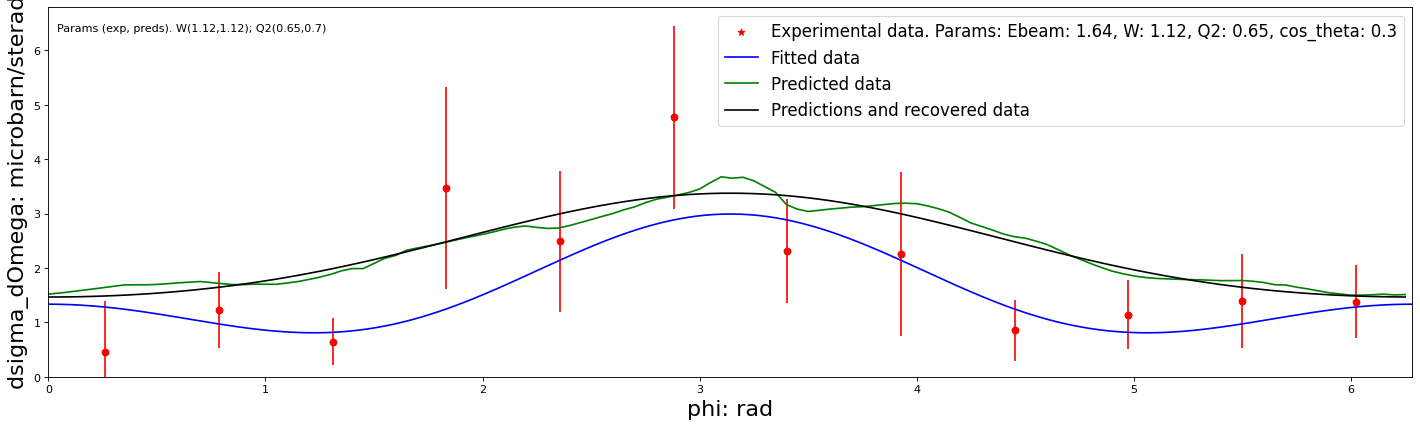

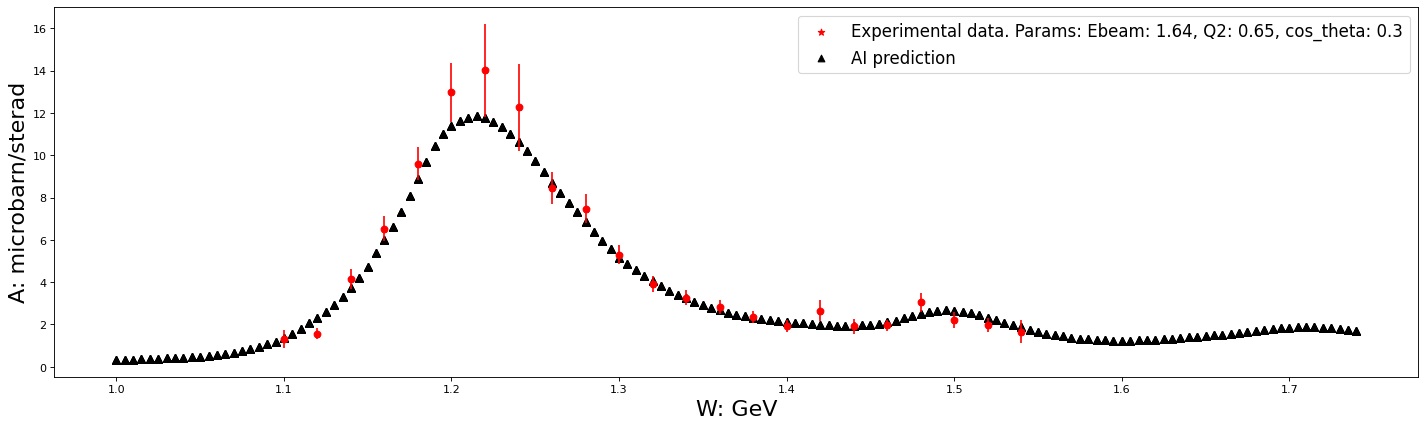

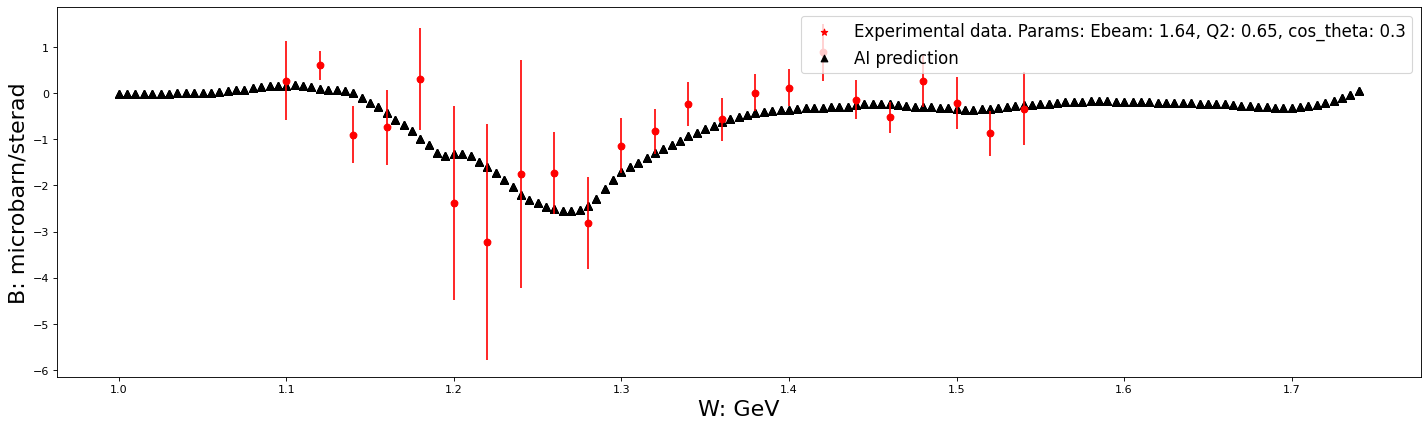

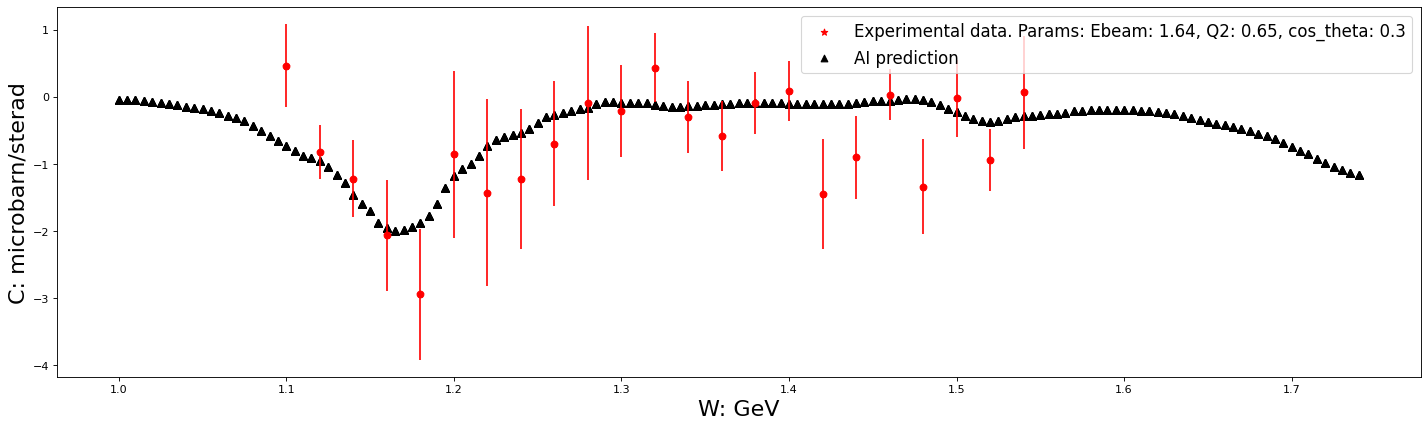

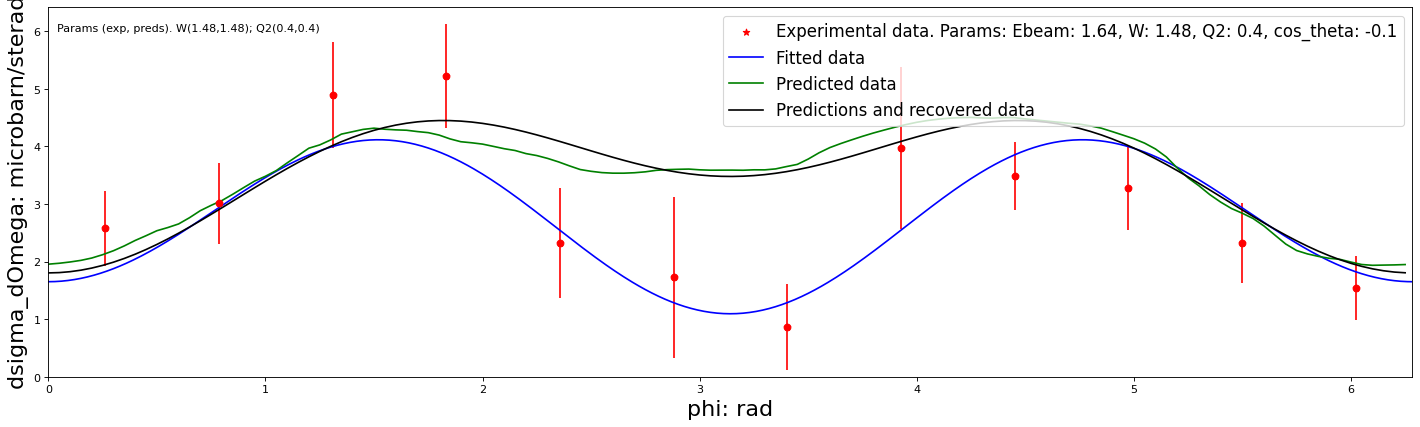

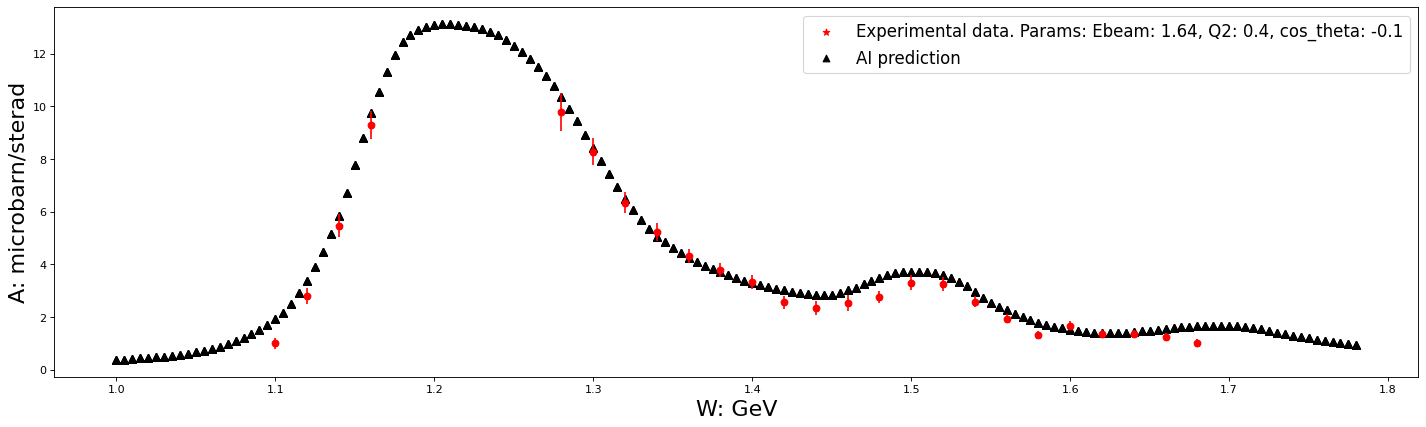

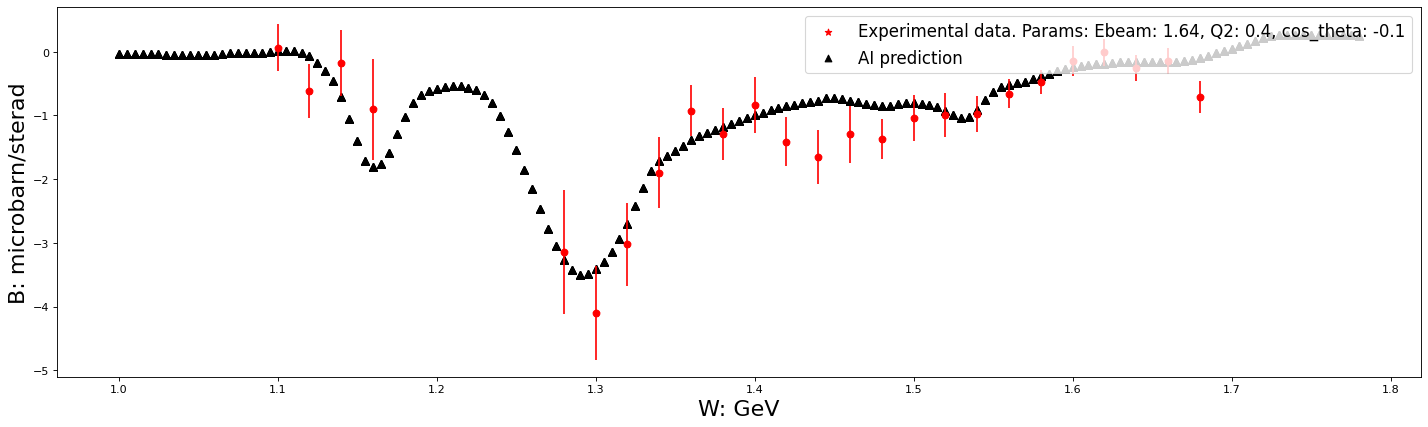

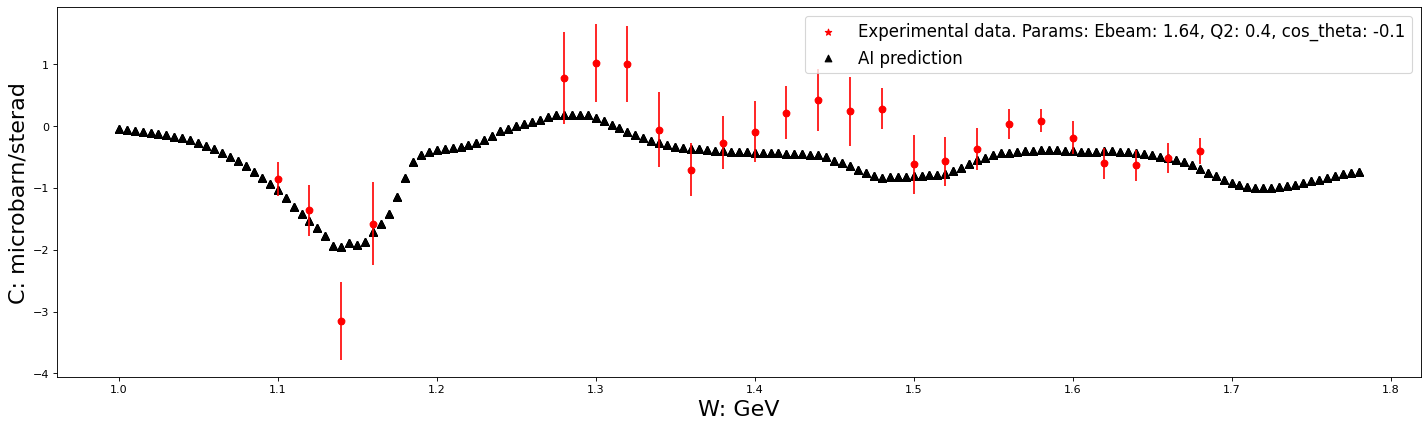

100%|██████████| 157/157 [00:09<00:00, 16.39it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-11-cf7548519599>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25132043430542883' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-cf7548519599>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.013366100520682475' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

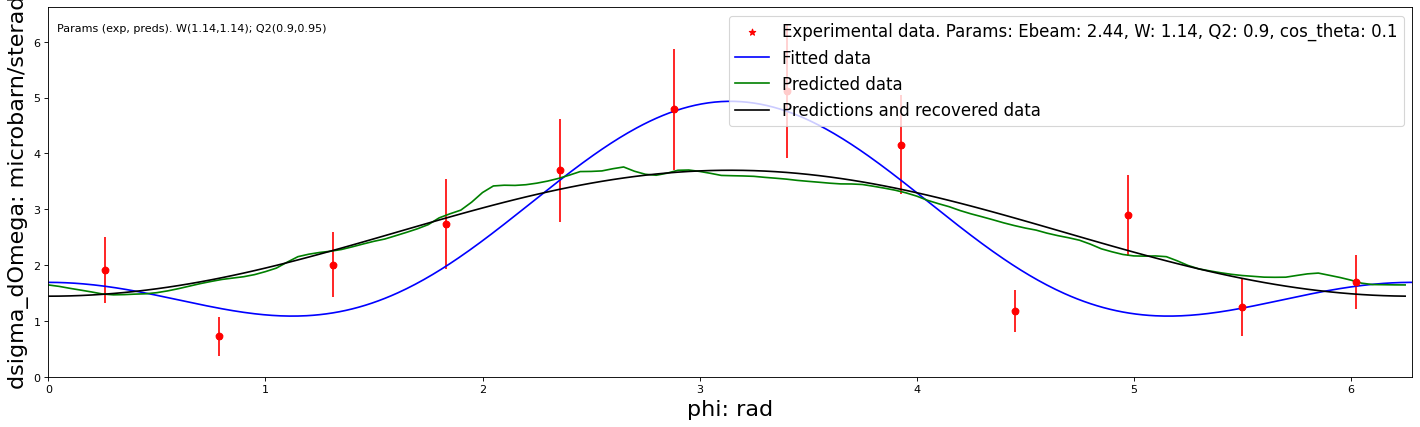

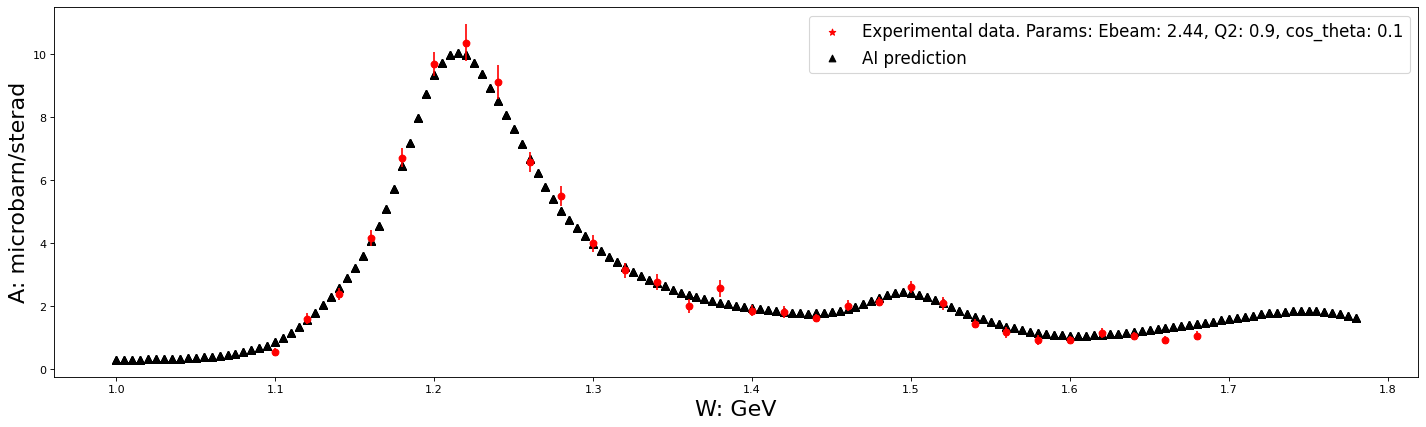

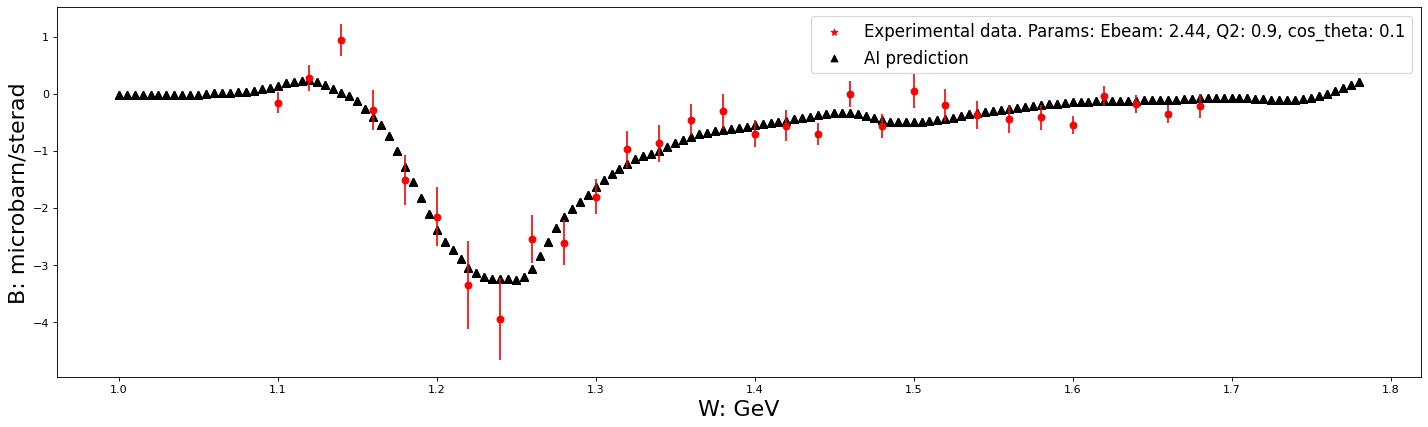

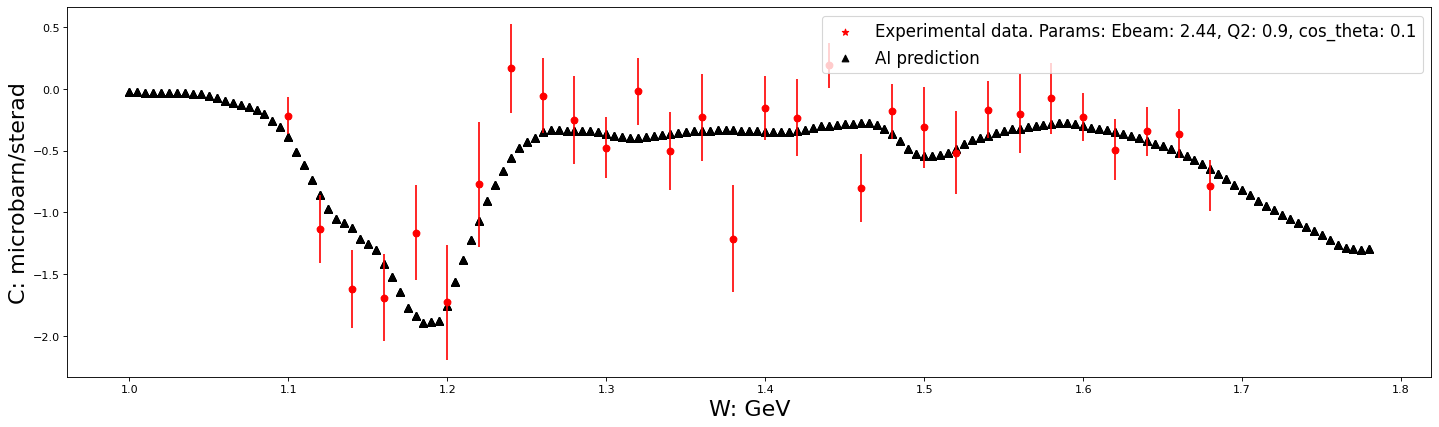

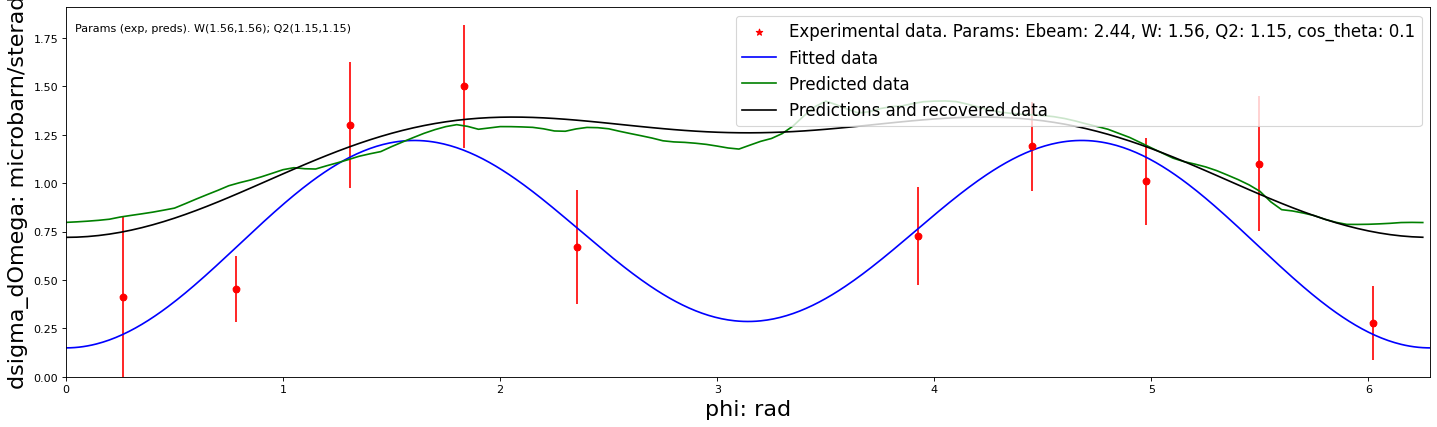

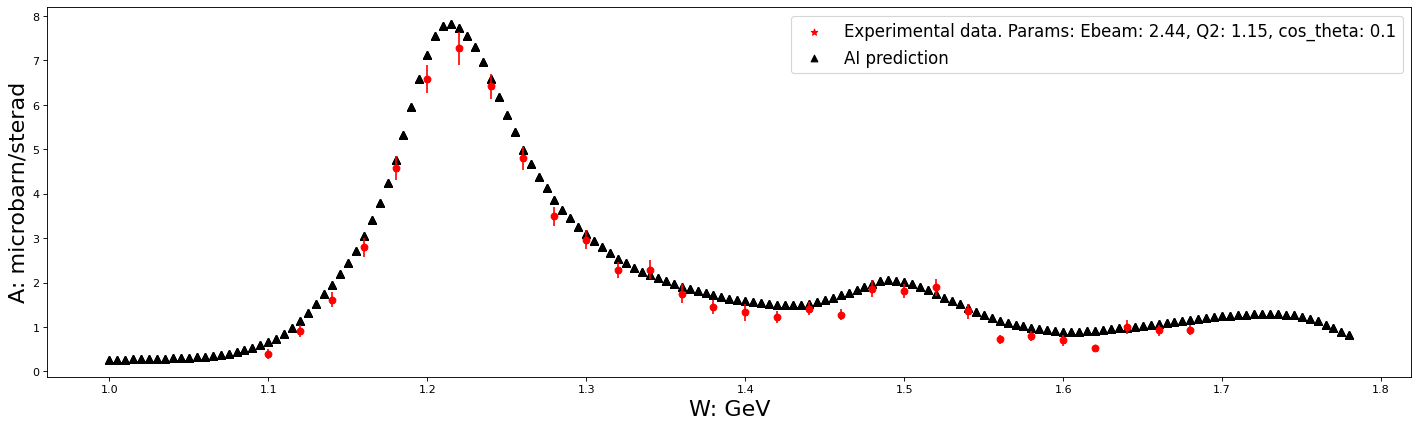

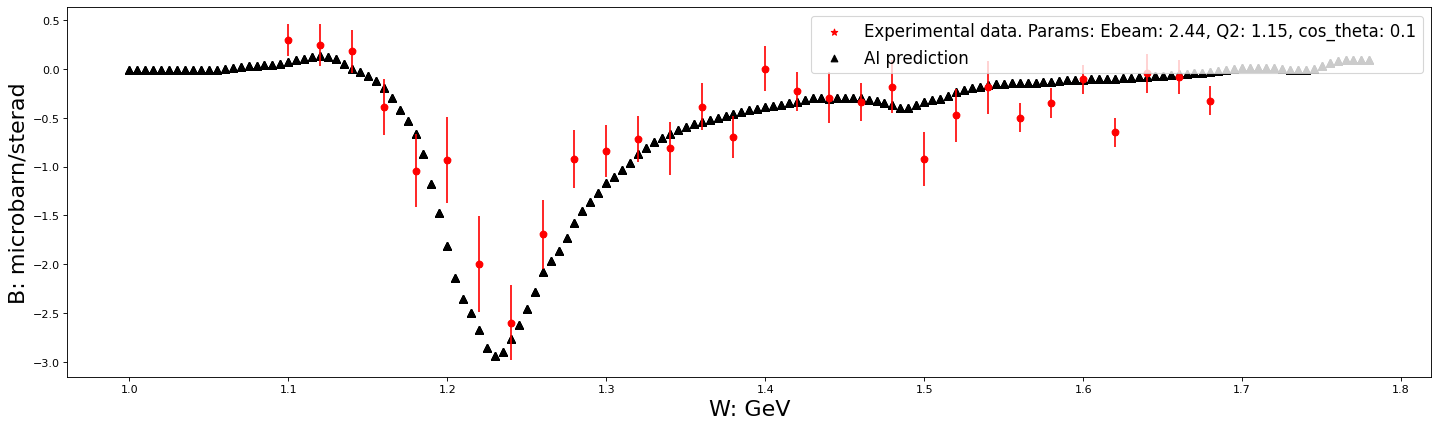

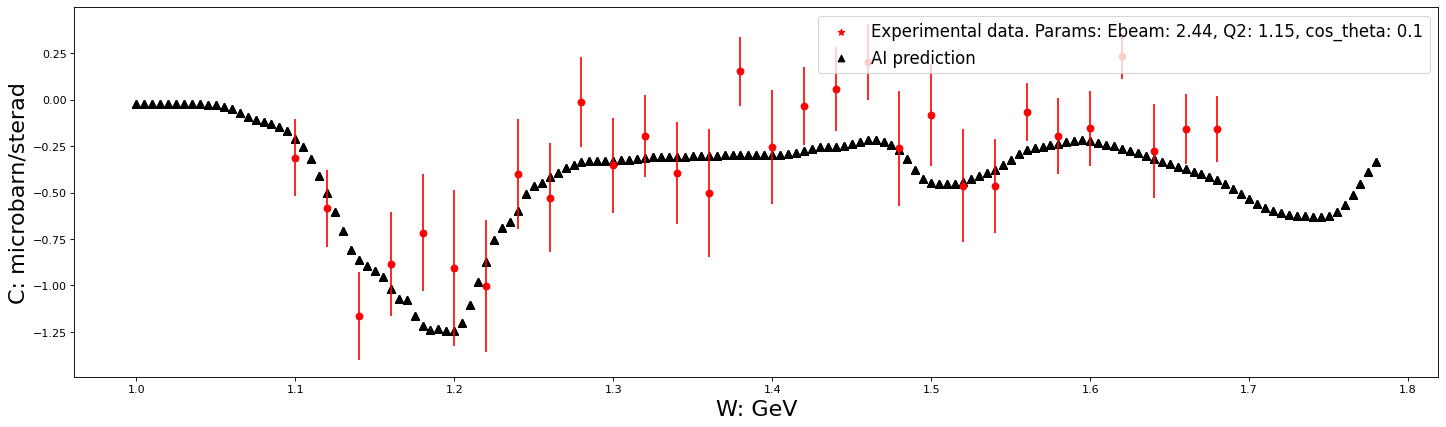

100%|██████████| 97/97 [00:10<00:00,  9.28it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-11-cf7548519599>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05079421958261538' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-cf7548519599>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.011514099082907773' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inp

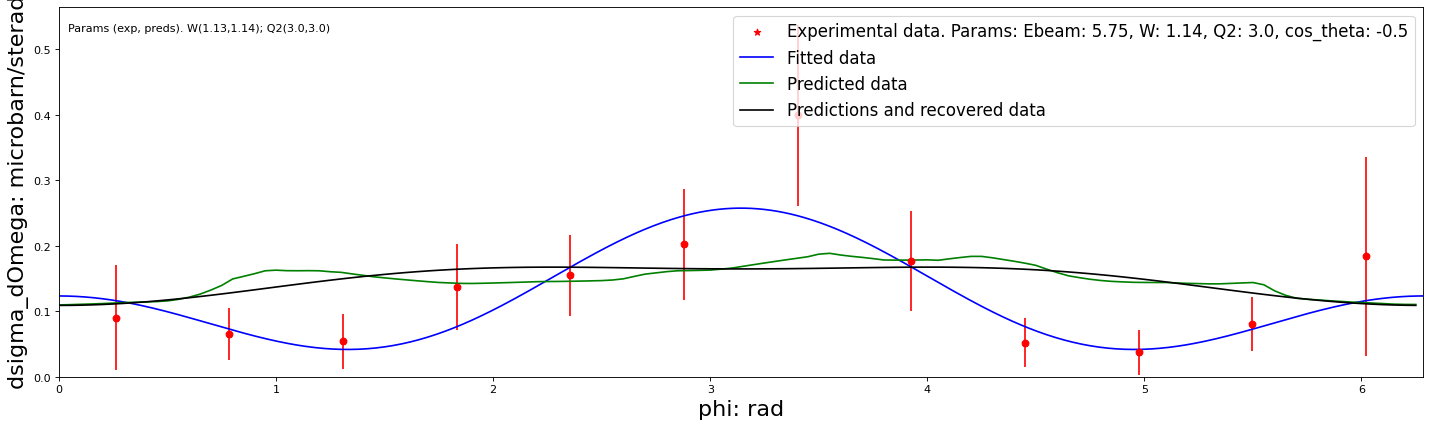

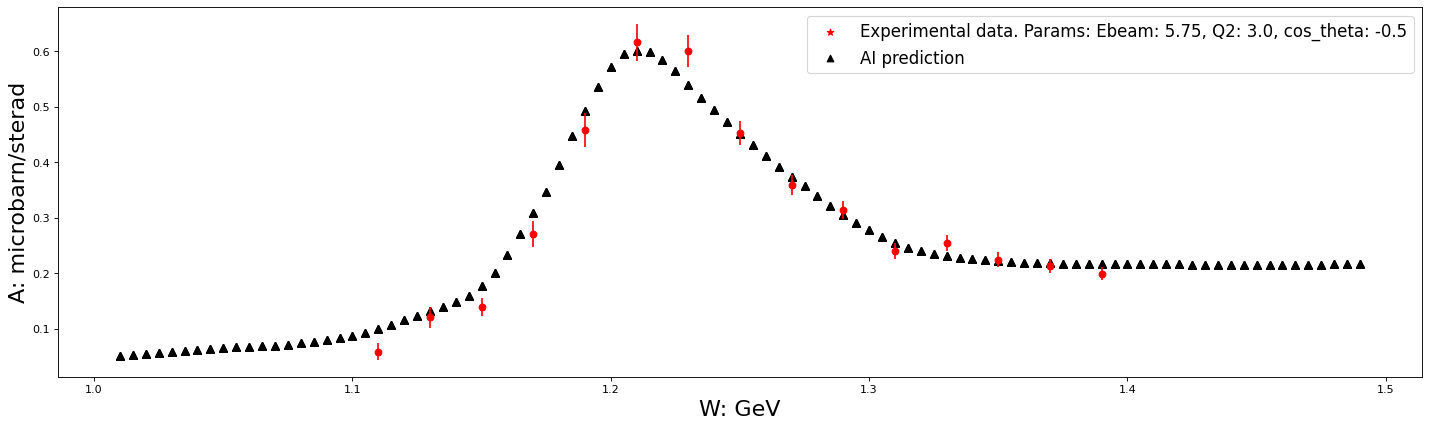

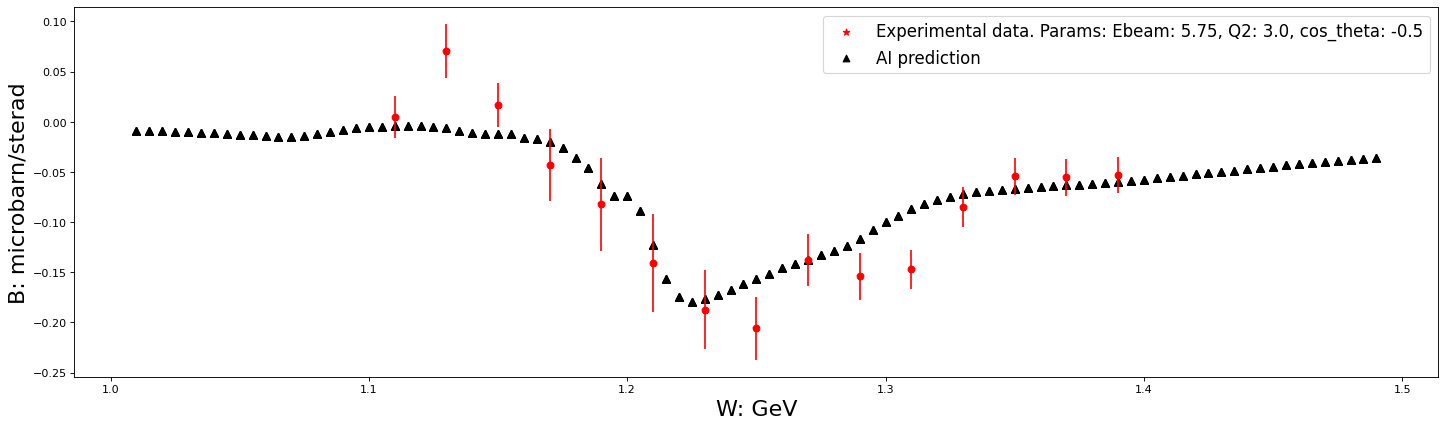

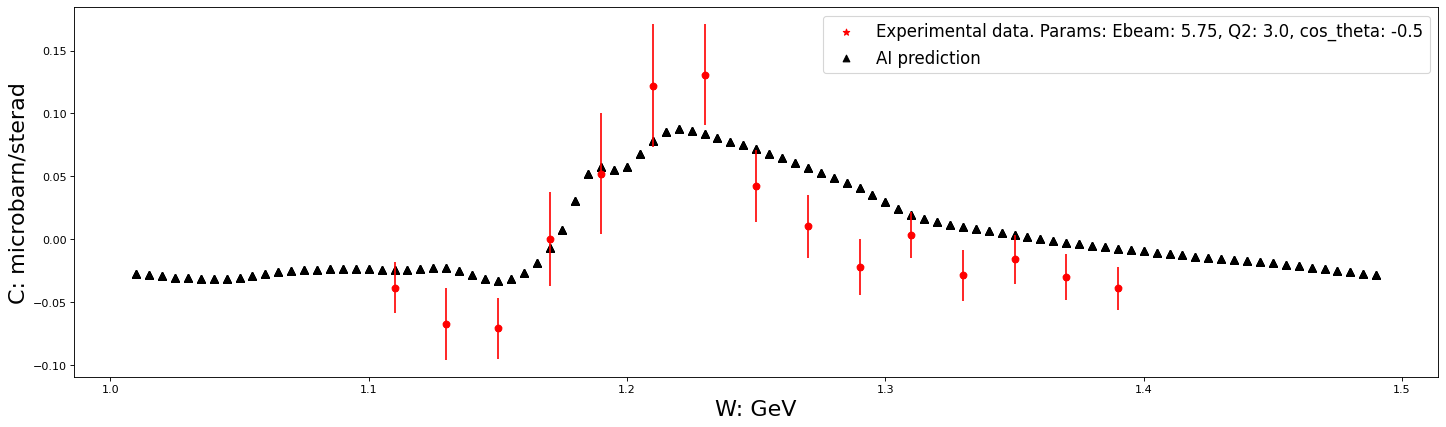

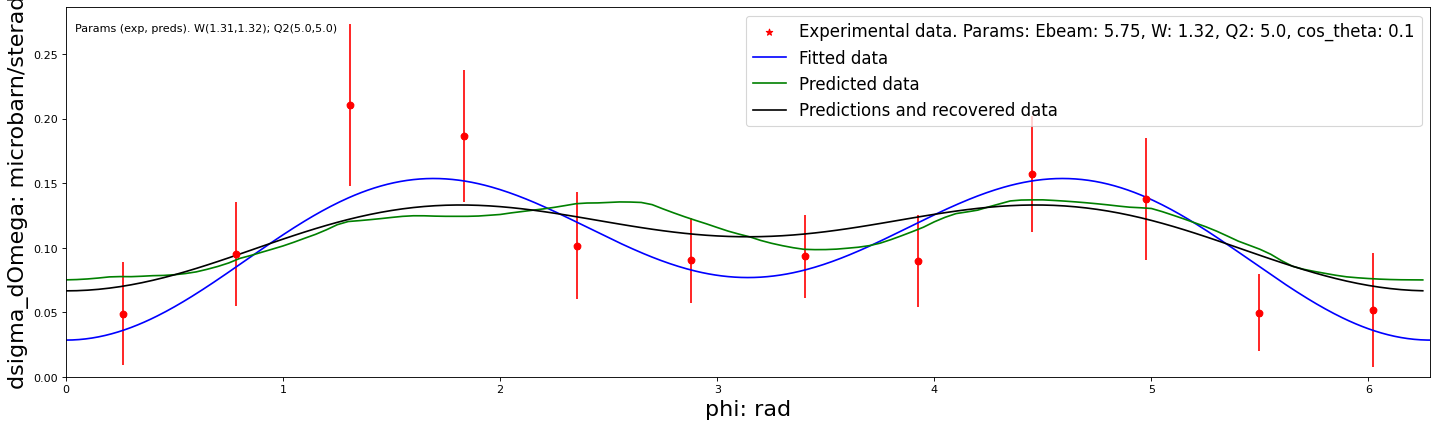

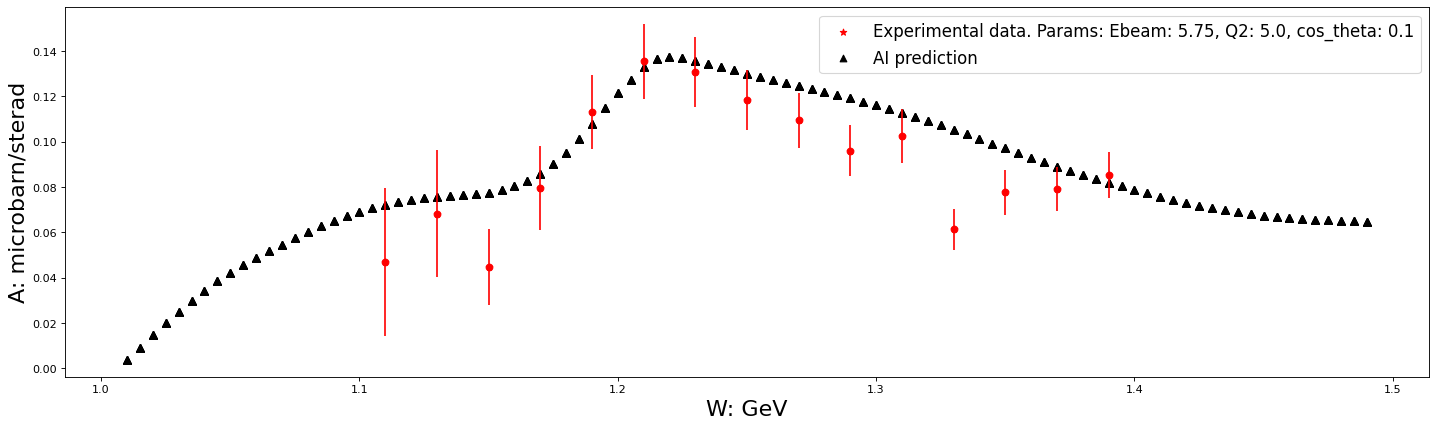

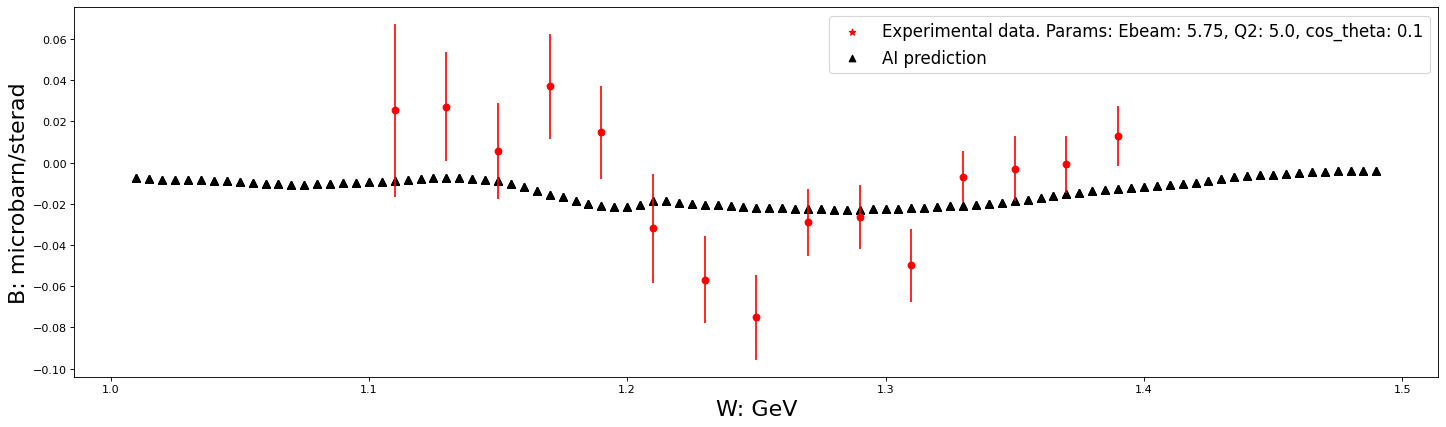

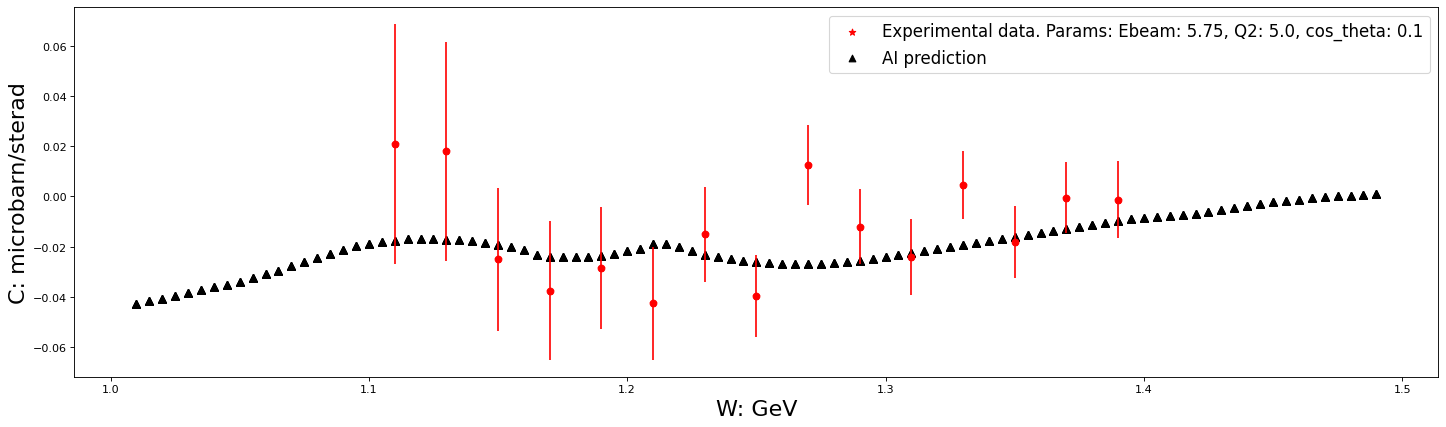

100%|██████████| 177/177 [00:04<00:00, 37.73it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-11-cf7548519599>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24496598678385514' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-cf7548519599>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01470070192574241' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

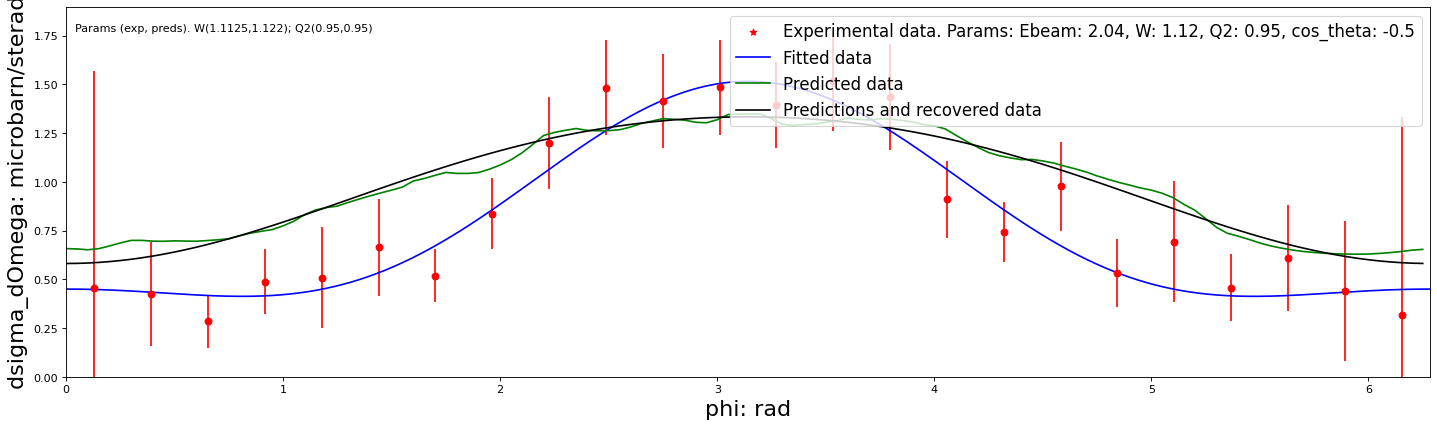

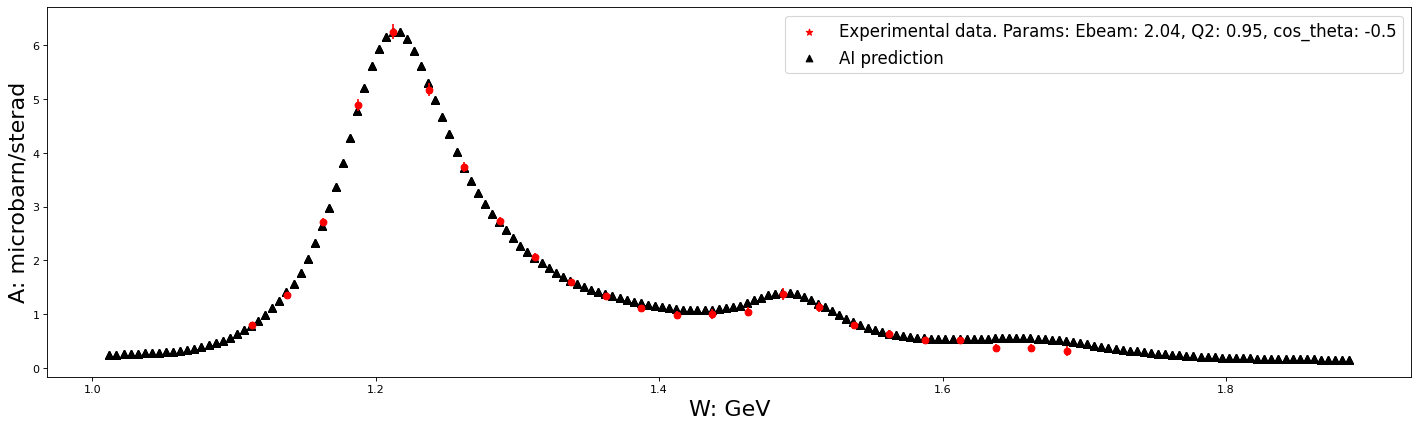

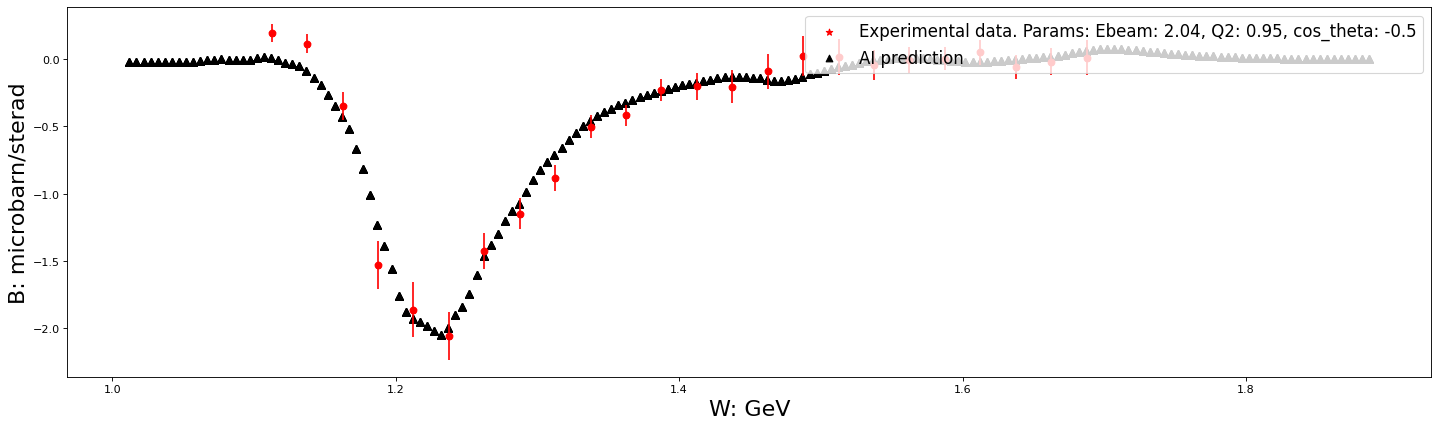

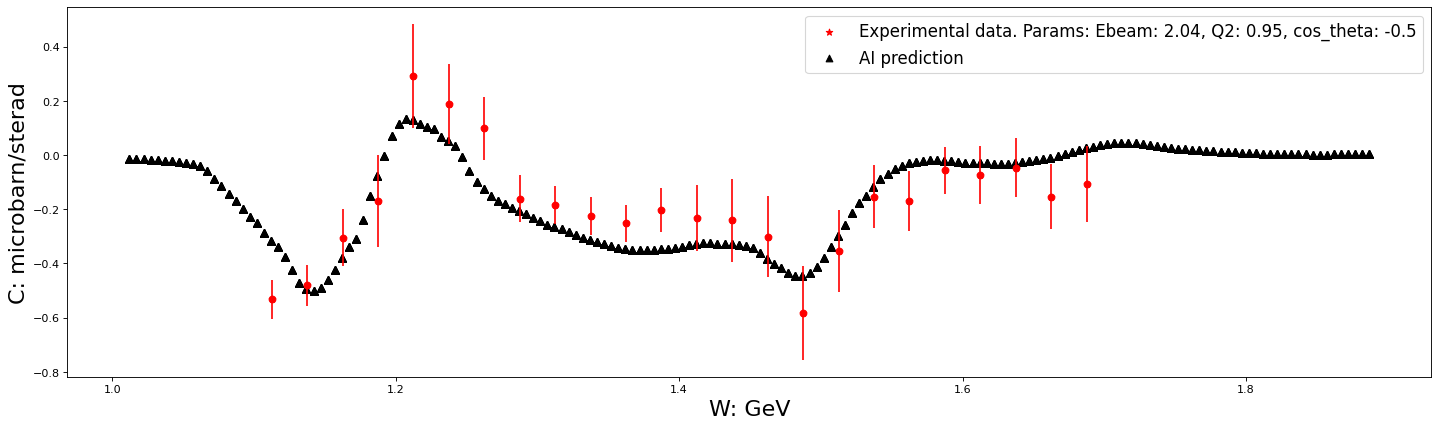

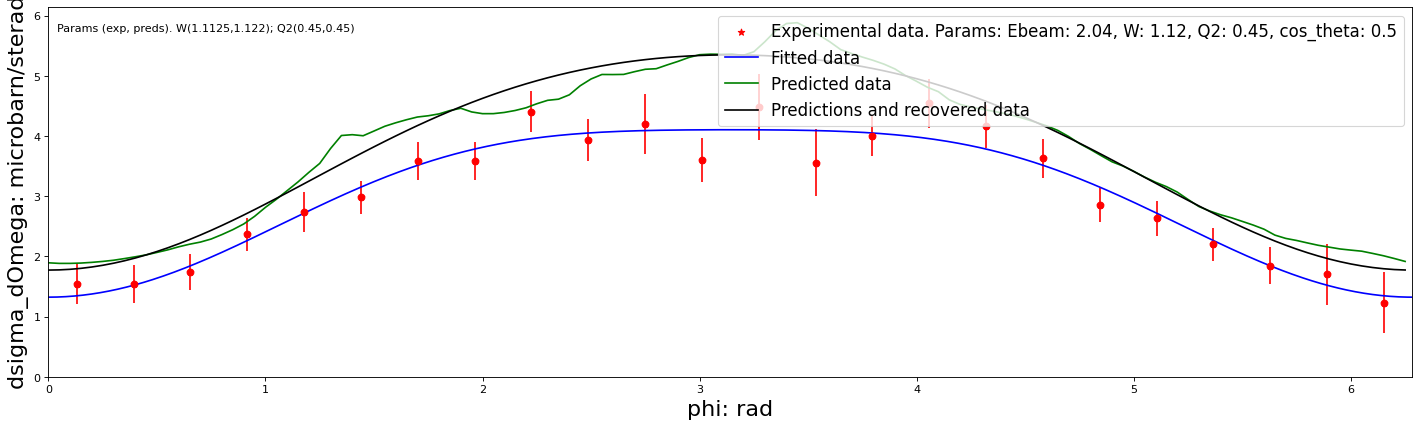

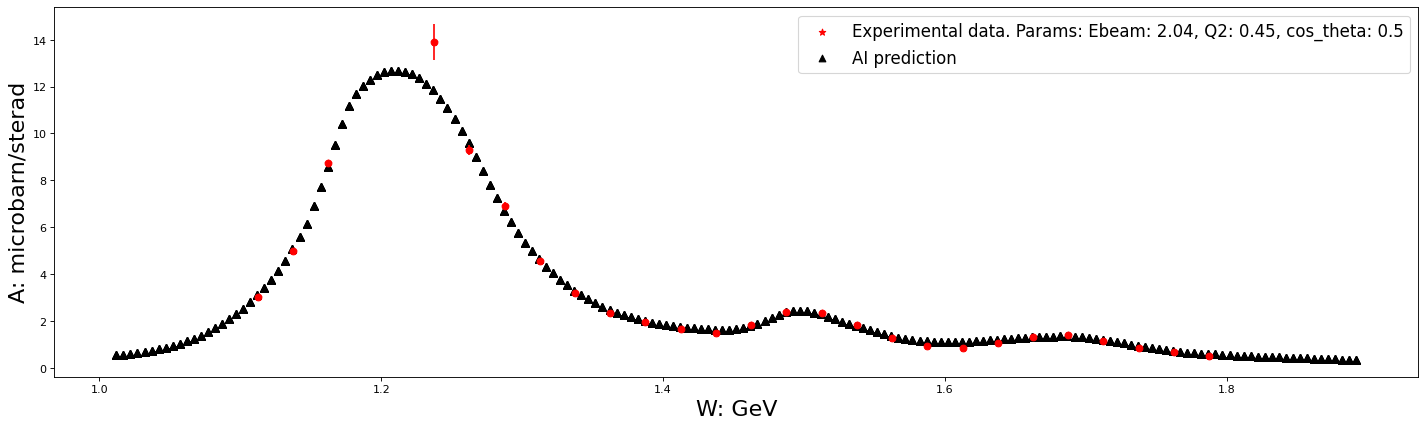

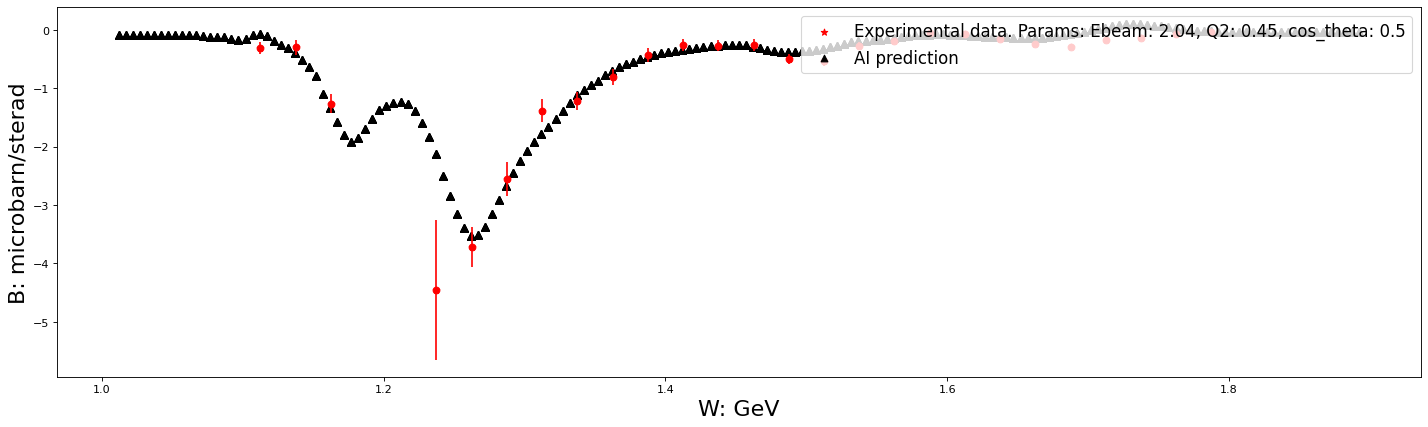

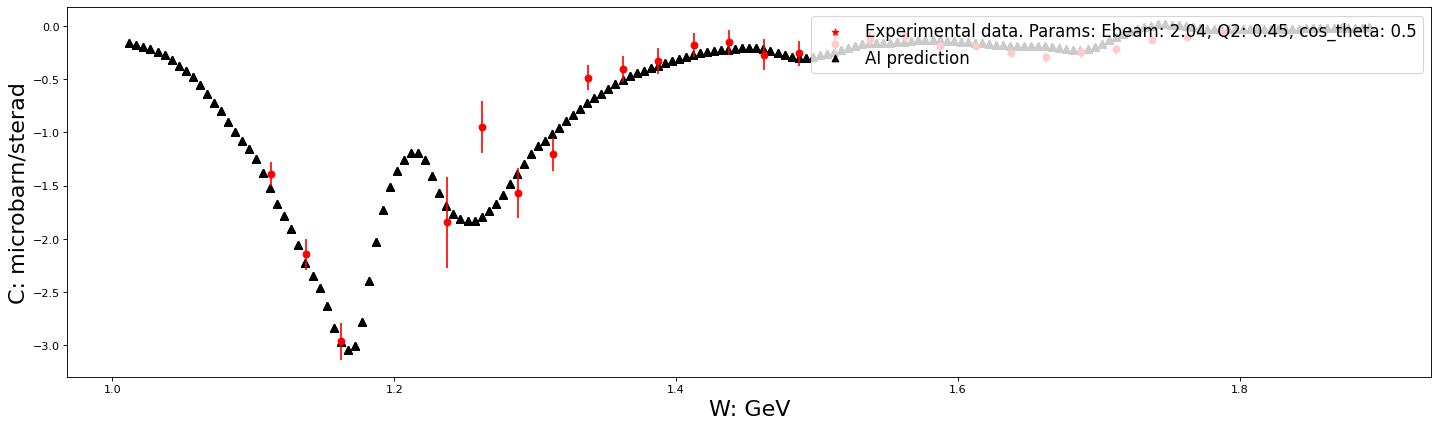

In [13]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [14]:
# Log results to W&B Media

for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
    for file in files:
        path_to_img = os.path.join(root, file)
        im = plt.imread(path_to_img)
        wandb.log({"img": [wandb.Image(path_to_img)]})

2024-12-08 23:44:38,462 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:38,467 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:38,469 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:38,471 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-08 23:44:38,520 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:38,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:38,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:38,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-08 23:44:38,559 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-08 23:44:38,623 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-08 23:44:38,679 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-08 23:44:38,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:38,695 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:38,699 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:38,701 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-08 23:44:38,728 : DEBUG : STREAM b'IHDR' 16 13
202

In [15]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-08 23:44:43,731 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:43,734 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:43,736 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:43,739 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-08 23:44:43,768 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:43,770 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:43,773 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:43,775 : DEBUG : STREAM b'IDAT' 131 37901
2024-12-08 23:44:43,795 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:43,798 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:43,802 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:43,805 : DEBUG : STREAM b'IDAT' 131 36637
2024-12-08 23:44:43,827 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:43,831 : DEBUG : STREAM b'tEXt' 41 57
2024-12-08 23:44:43,833 : DEBUG : STREAM b'pHYs' 110 9
2024-12-08 23:44:43,836 : DEBUG : STREAM b'IDAT' 131 36302
2024-12-08 23:44:43,859 : DEBUG : STREAM b'IHDR' 16 13
2024-12-08 23:44:43,862 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [16]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,████▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▆▇▇▇███████████████████████████████████
train_rmse,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,██▄▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▇▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,██▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 157/157 [00:04<00:00, 33.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3846924947271446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006029384299421474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

2024-12-03 16:02:50,100 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-03 16:02:50,103 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-03 16:02:50,106 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-12-03 16:02:50,109 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-03 16:02:50,111 : DEBUG : findfont: sc

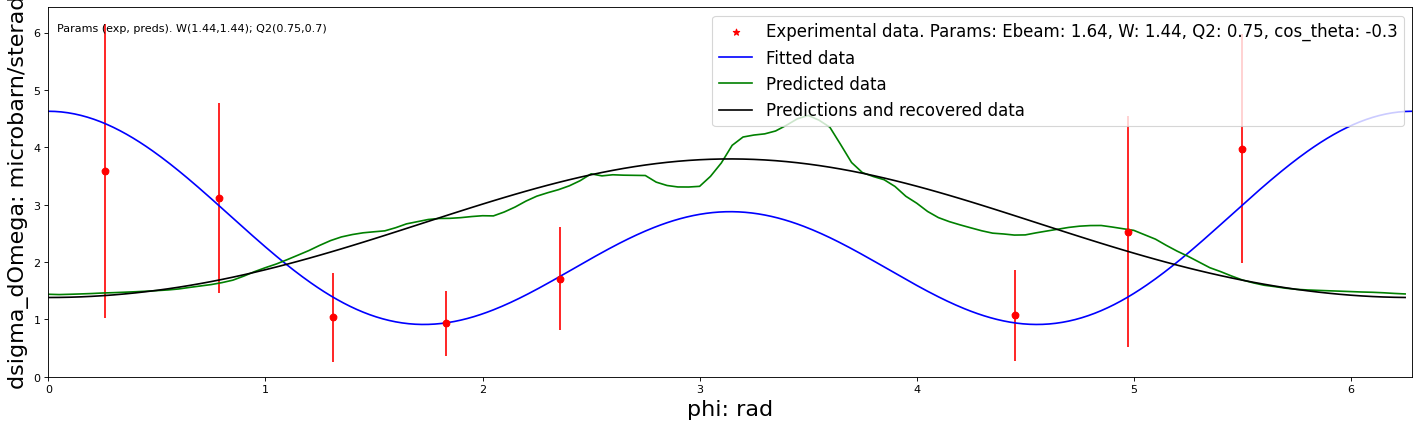

2024-12-03 16:02:52,649 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,651 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:52,653 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:52,655 : DEBUG : STREAM b'IDAT' 131 36433
2024-12-03 16:02:52,787 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,790 : DEBUG : STREAM b'IDAT' 41 36433


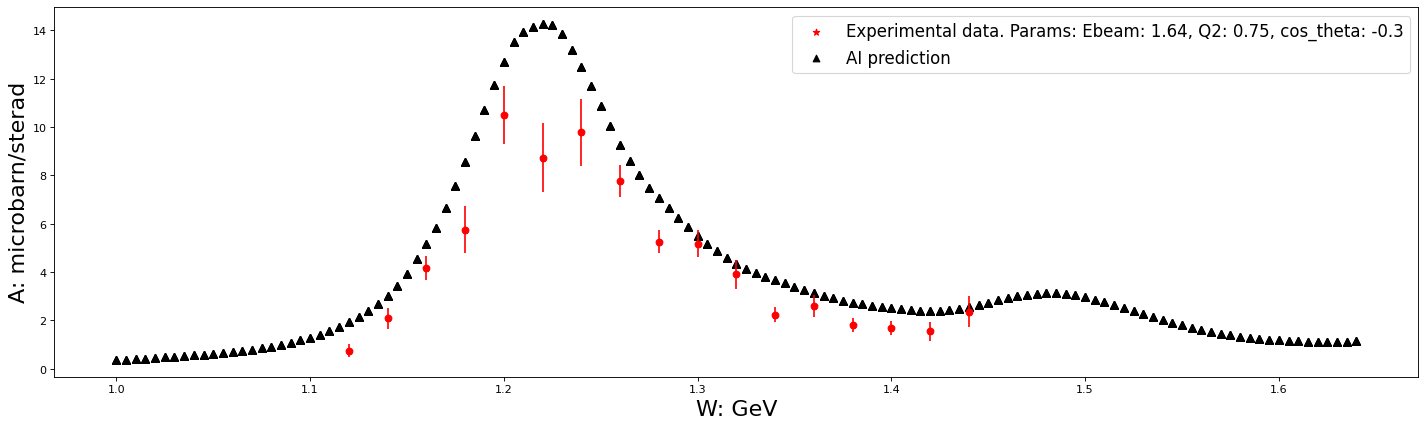

2024-12-03 16:02:53,850 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,852 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:53,854 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:53,856 : DEBUG : STREAM b'IDAT' 131 35982
2024-12-03 16:02:53,938 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,940 : DEBUG : STREAM b'IDAT' 41 35982


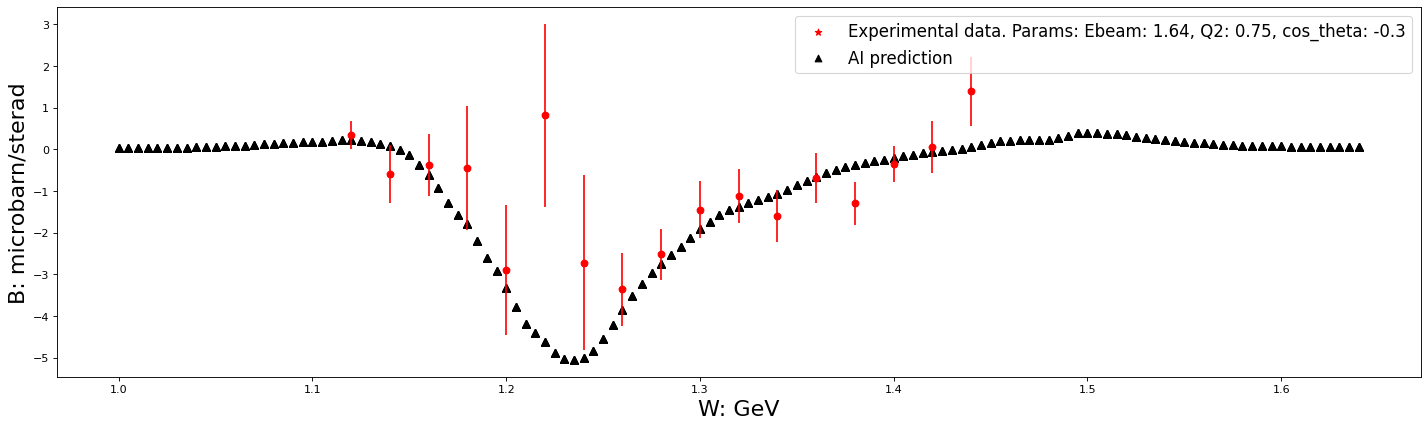

2024-12-03 16:02:54,613 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,615 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:54,617 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:54,620 : DEBUG : STREAM b'IDAT' 131 36865
2024-12-03 16:02:54,704 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,706 : DEBUG : STREAM b'IDAT' 41 36865


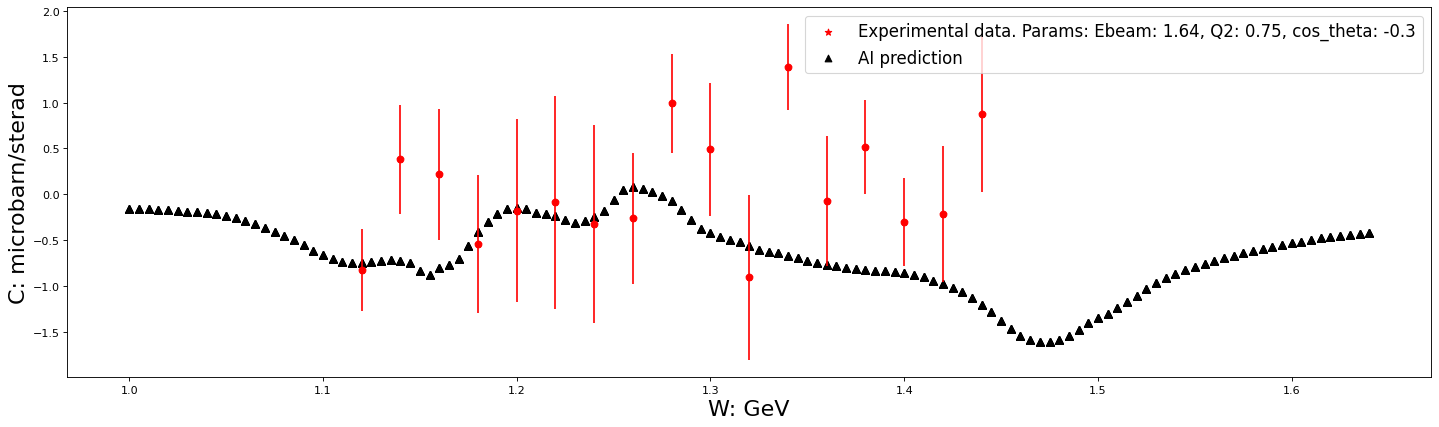

1
2024-12-03 16:02:55,385 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,387 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:55,390 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:55,394 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:02:55,485 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,488 : DEBUG : STREAM b'IDAT' 41 65536


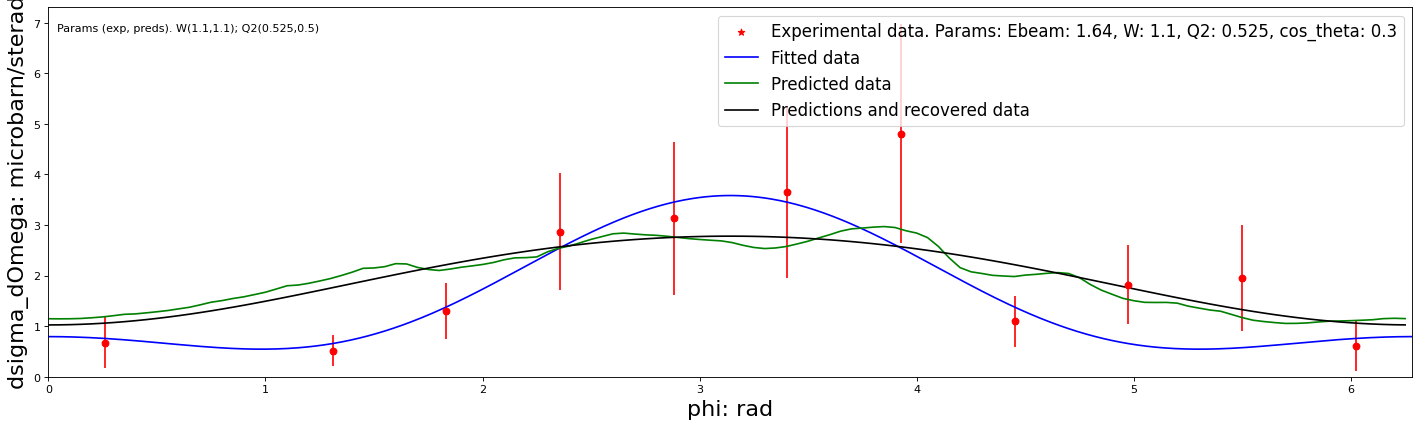

2024-12-03 16:02:56,183 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,185 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:56,191 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:56,195 : DEBUG : STREAM b'IDAT' 131 37516
2024-12-03 16:02:56,292 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,295 : DEBUG : STREAM b'IDAT' 41 37516


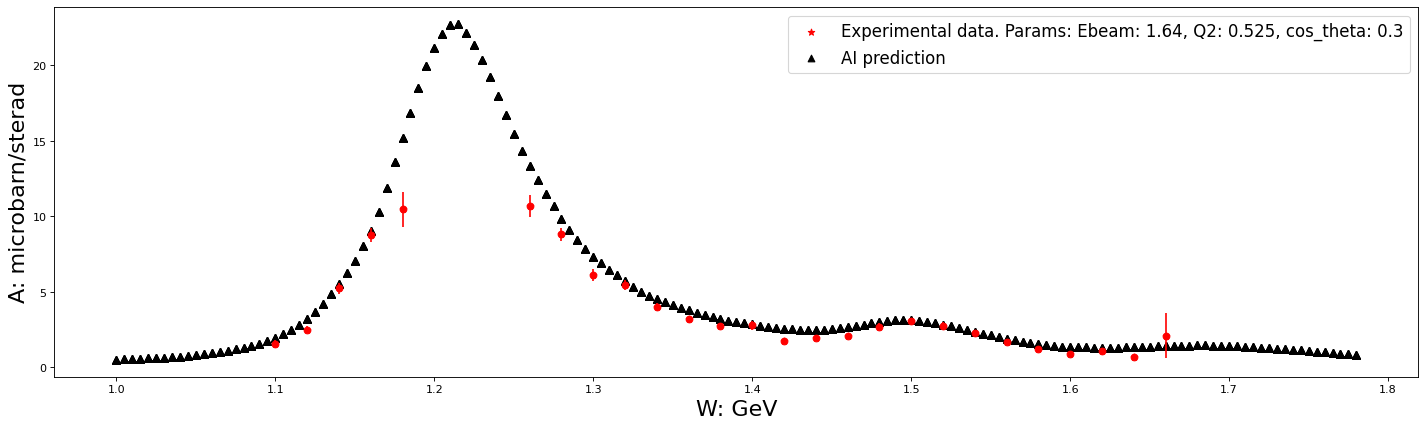

2024-12-03 16:02:56,996 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,998 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,000 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,002 : DEBUG : STREAM b'IDAT' 131 36214
2024-12-03 16:02:57,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,086 : DEBUG : STREAM b'IDAT' 41 36214


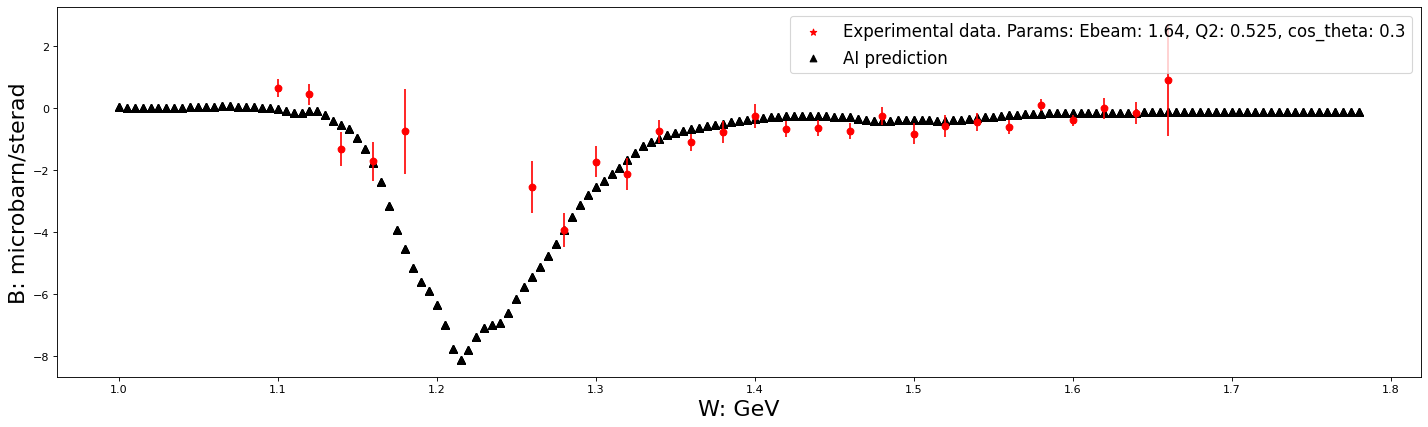

2024-12-03 16:02:57,790 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,792 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,795 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,798 : DEBUG : STREAM b'IDAT' 131 36991
2024-12-03 16:02:57,884 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,886 : DEBUG : STREAM b'IDAT' 41 36991


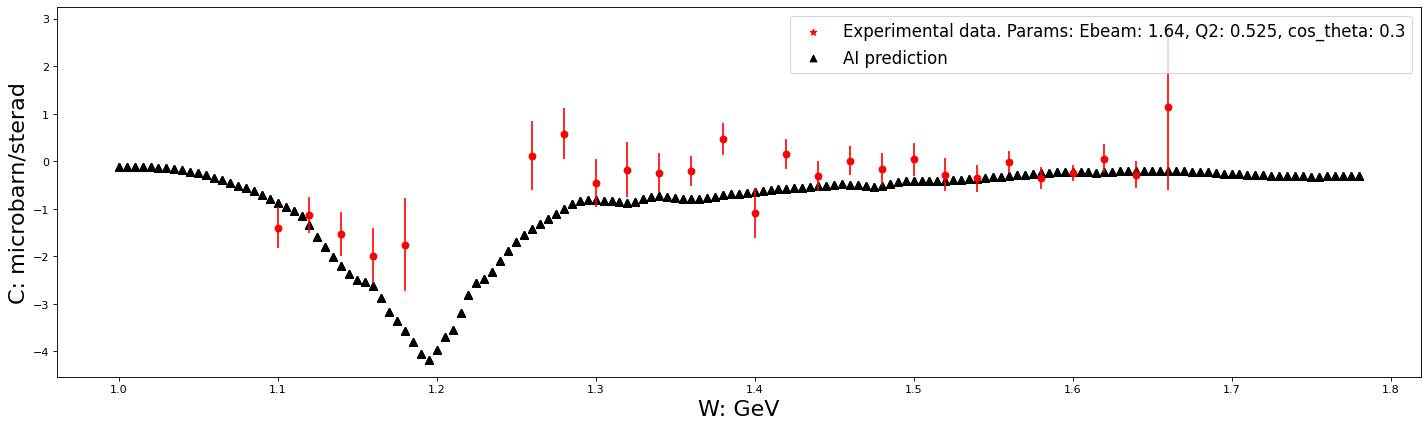

2


100%|██████████| 157/157 [00:07<00:00, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3759944385466103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06444017856602151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-

2024-12-03 16:17:39,521 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:39,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:39,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:39,644 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,647 : DEBUG : STREAM b'IDAT' 41 65536


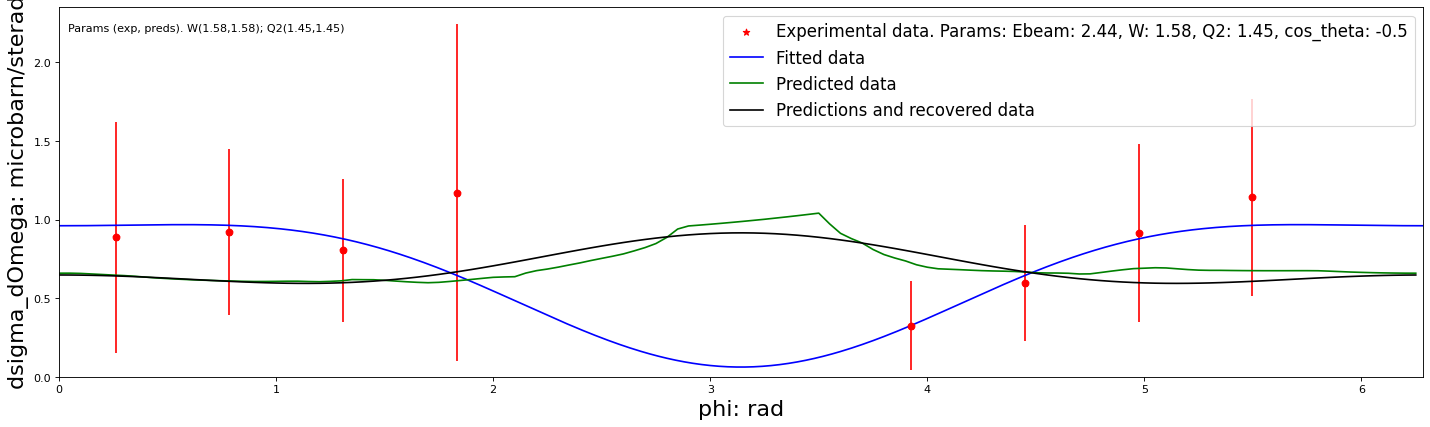

2024-12-03 16:17:40,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,533 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:40,535 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:40,537 : DEBUG : STREAM b'IDAT' 131 39649
2024-12-03 16:17:40,633 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,636 : DEBUG : STREAM b'IDAT' 41 39649


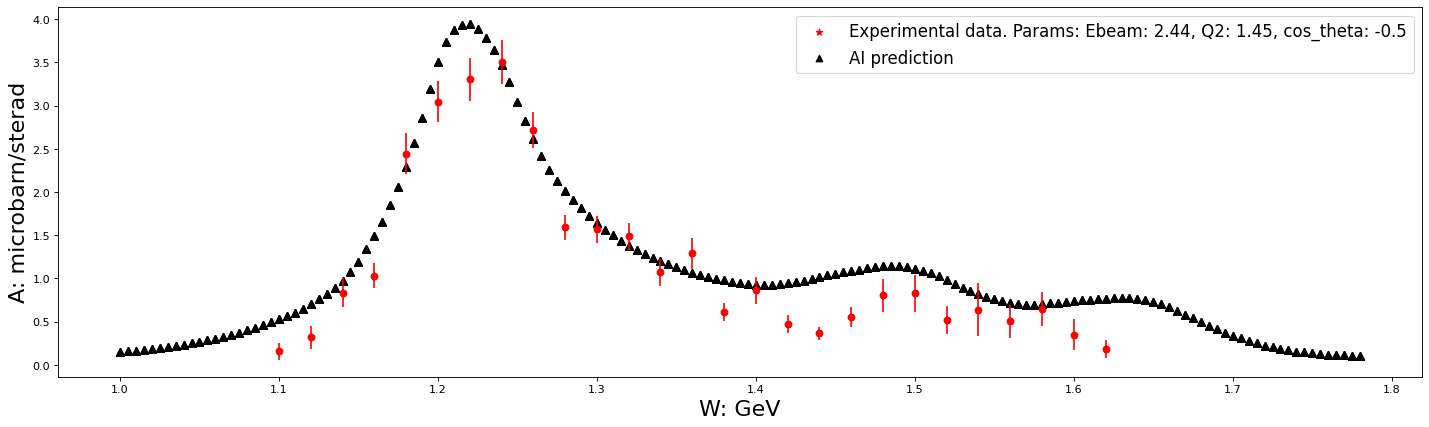

2024-12-03 16:17:41,532 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,534 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:41,537 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:41,539 : DEBUG : STREAM b'IDAT' 131 39774
2024-12-03 16:17:41,635 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,641 : DEBUG : STREAM b'IDAT' 41 39774


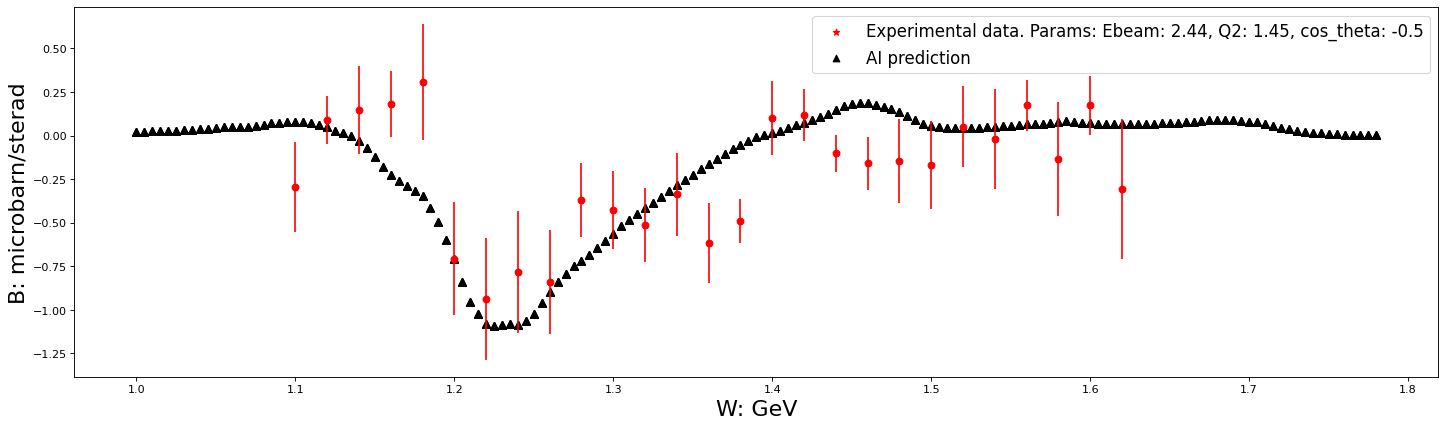

2024-12-03 16:17:42,570 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,574 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:42,576 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:42,579 : DEBUG : STREAM b'IDAT' 131 40327
2024-12-03 16:17:42,675 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,677 : DEBUG : STREAM b'IDAT' 41 40327


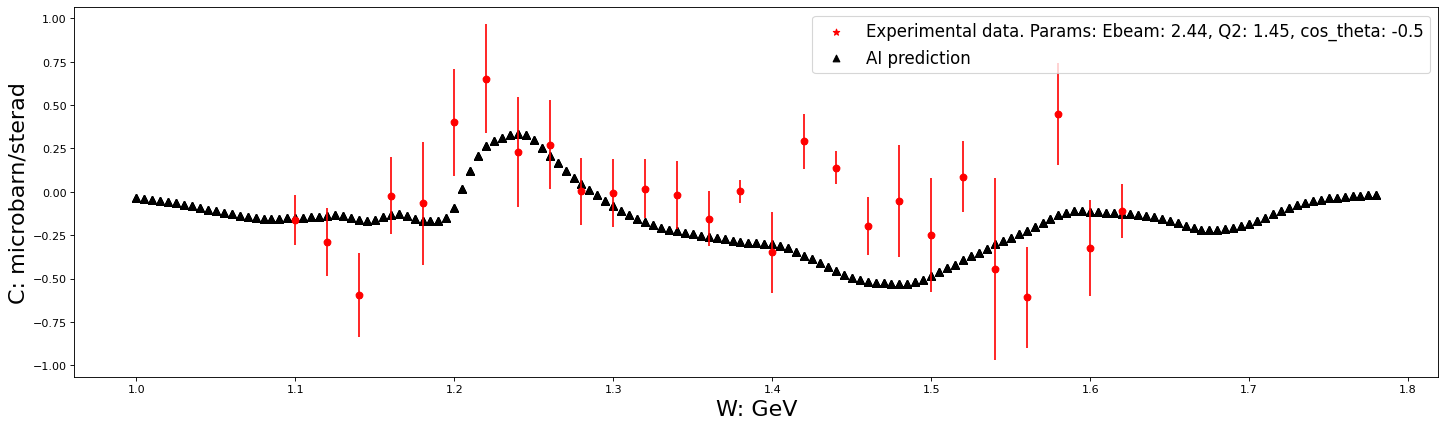

1
2024-12-03 16:17:43,580 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,582 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:43,585 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:43,588 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:43,687 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,692 : DEBUG : STREAM b'IDAT' 41 65536


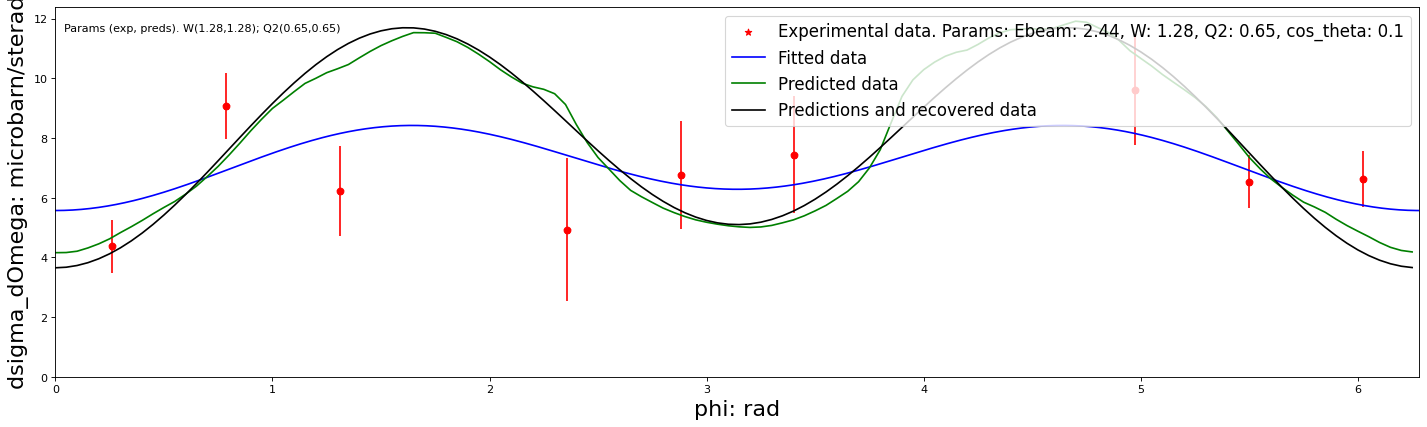

2024-12-03 16:17:44,586 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,589 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:44,591 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:44,594 : DEBUG : STREAM b'IDAT' 131 39500
2024-12-03 16:17:44,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,693 : DEBUG : STREAM b'IDAT' 41 39500


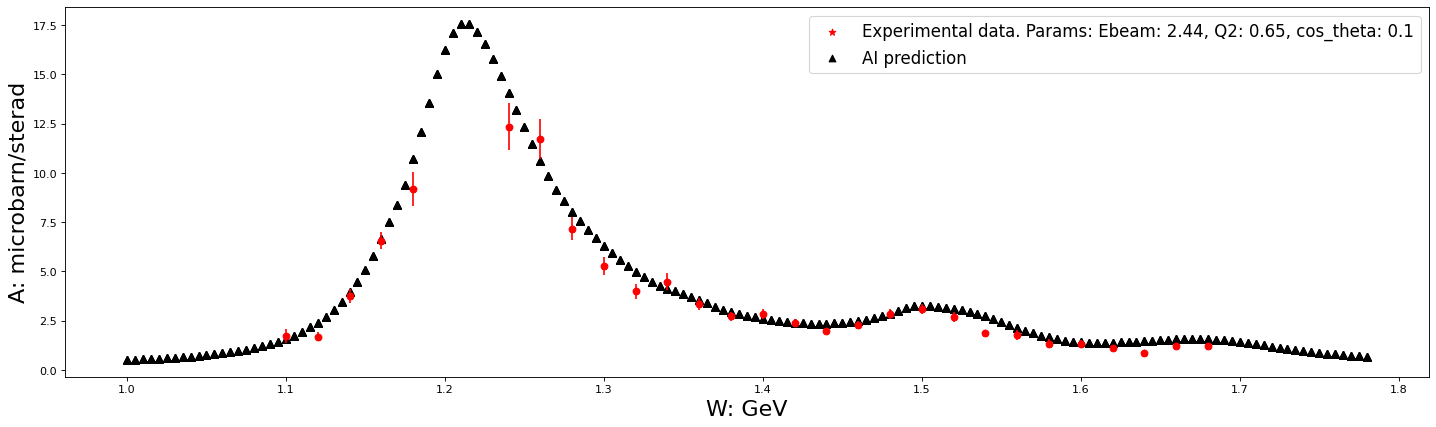

2024-12-03 16:17:45,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:45,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:45,599 : DEBUG : STREAM b'IDAT' 131 36530
2024-12-03 16:17:45,692 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,694 : DEBUG : STREAM b'IDAT' 41 36530


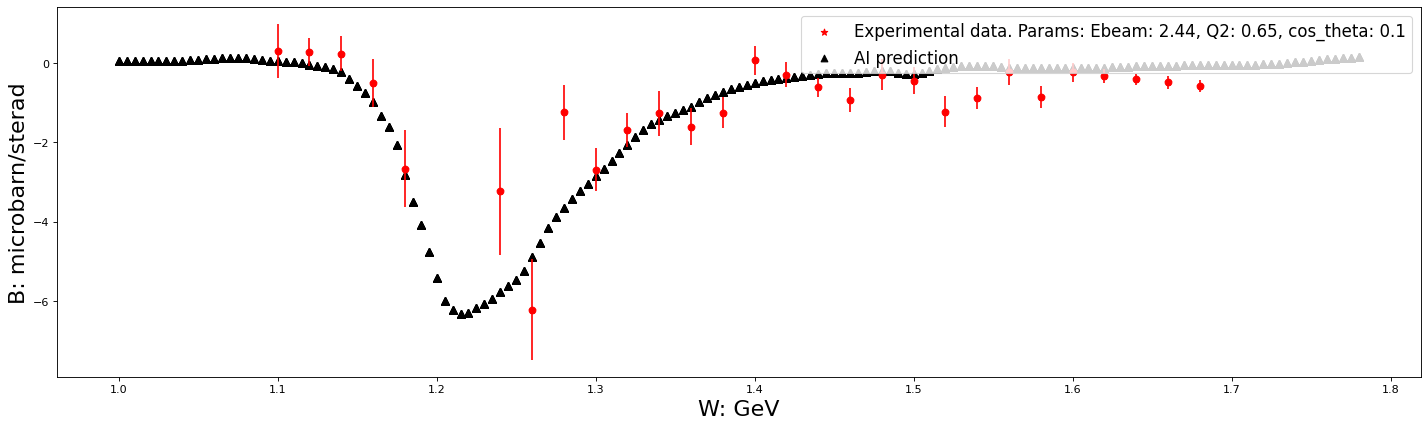

2024-12-03 16:17:46,823 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,828 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:46,830 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:46,833 : DEBUG : STREAM b'IDAT' 131 39694
2024-12-03 16:17:46,983 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,988 : DEBUG : STREAM b'IDAT' 41 39694


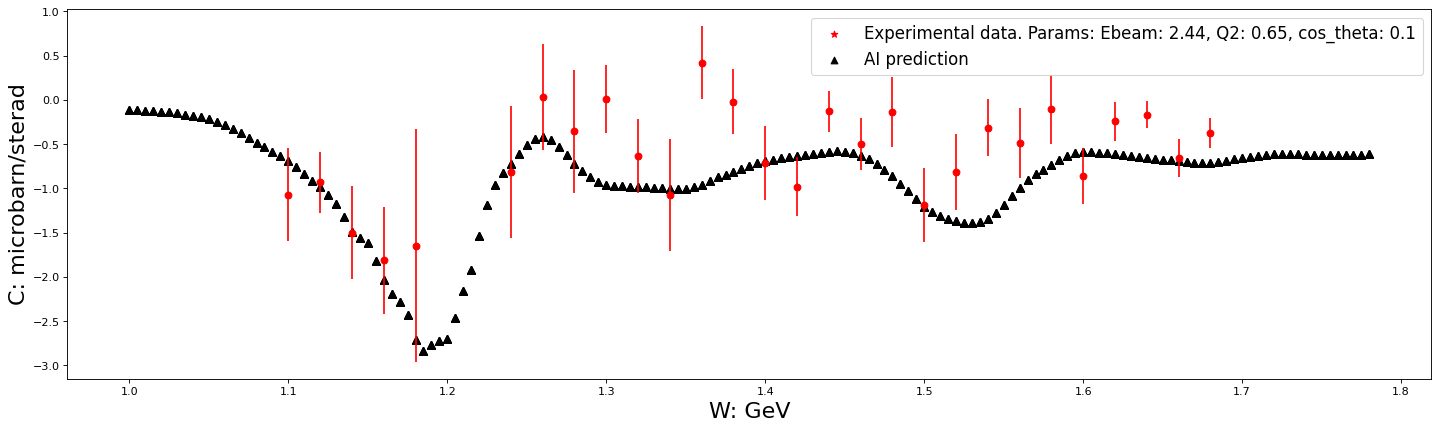

2


100%|██████████| 97/97 [00:09<00:00, 10.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 24%|██▍       | 24/100 [04:08<13:07, 10.36s/it]


KeyboardInterrupt: 

In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False